In [1]:
from scipy.integrate import quad
import glob
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline

In [2]:
def load_file_paths(base_dir):
    file_paths = []
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file == "chemical_and_SN_evolution.txt":
                file_paths.append(os.path.join(root, file))
    return file_paths

def load_data_with_names(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    data_dict = {}
    for i in range(len(lines)):
        line = lines[i].strip()
        if line.startswith("#"):
            row_name = line[1:].strip()
            if i + 1 < len(lines):
                data = list(map(float, lines[i + 1].strip().split()))
                data_dict[row_name] = data
    return data_dict

def recalculate(logNO, logOH): # Recalculate logNO and logOH
    logNO = [i - 0.86 for i in logNO]
    logOH = [i + 8.696 for i in logOH]
    return logNO, logOH

def fit(logOH, logNO): # Fit a polynomial to the data
    coefficients = np.polyfit(logOH, logNO, deg=6)
    polynomial = np.poly1d(coefficients)
    smooth_logOH = np.linspace(min(logOH[6:]), max(logOH[6:]), 500)
    smooth_logNO = polynomial(smooth_logOH)
    return smooth_logOH, smooth_logNO

def prepare_data(file_paths):
    for path in file_paths:
        data = load_data_with_names(path)
        logNO, logOH = data['Gas [N/O]:'], data['Gas [O/H]:']
        FeH, MgH, OH = data['Gas [Fe/H]:'], data['Gas [Mg/H]:'], data['Gas [O/H]:']
        timestep = data['time step list:']
        logNO_rec, logOH_rec = recalculate(logNO, logOH)
        smooth_logOH, smooth_logNO = fit(logOH_rec, logNO_rec)
    return smooth_logOH, smooth_logNO

def plot_Bekki_comparison():
    patha115 = "./Bekki paper stolen plots/alpha115.csv"
    patha155 = "./Bekki paper stolen plots/alpha155.csv"
    patha235 = "./Bekki paper stolen plots/alpha235.csv"
    pathdwarf = "./Bekki paper stolen plots/dwarf.csv"

    a115 = np.loadtxt(patha115, delimiter=',')
    a155 = np.loadtxt(patha155, delimiter=',')
    a235 = np.loadtxt(patha235, delimiter=',')
    dwarf = np.loadtxt(pathdwarf, delimiter=',')

    BlogOHa115 = a115[:, 0]
    BlogNOa115 = a115[:, 1]
    BlogOHa155 = a155[:, 0]
    BlogNOa155 = a155[:, 1]
    BlogOHa235 = a235[:, 0]
    BlogNOa235 = a235[:, 1]
    BlogOHdwarf = dwarf[:, 0]
    BlogNOdwarf = dwarf[:, 1]

    # plt.rc('font', family='serif')
    plt.plot(BlogOHa155, BlogNOa155, color='palevioletred', lw=1, label='Bekki, $\\alpha=1.55$', linestyle=':')
    plt.plot(BlogOHa115, BlogNOa115, color='deeppink', lw=1, label='Bekki, $\\alpha=1.15$', linestyle='-')
    plt.plot(BlogOHa235, BlogNOa235, color='crimson', lw=1, label='Bekki, $\\alpha=2.35$', linestyle='--')
    plt.plot(BlogOHdwarf, BlogNOdwarf, color='darkmagenta', lw=1, label='Bekki, dwarf', linestyle='-.')
    plt.scatter(7.559841776058438, -0.4, color='black', label='Bekki', s=30, marker='*')
    plt.scatter(8.696, -0.86, color='purple', label='Solar values', s=20, marker='*')
    plt.scatter(7.91, -0.2, color='red', label='Observations', s=30, marker='*')

def plot_evolution_track_difference(file_paths, index_x, index_y):
    assert len(file_paths) == 2 

    # Load and recalculate both yields
    data1 = load_data_with_names(file_paths[0])
    data2 = load_data_with_names(file_paths[1])
    logNO1, logOH1 = recalculate(data1['Gas [N/O]:'], data1['Gas [O/H]:'])
    logNO2, logOH2 = recalculate(data2['Gas [N/O]:'], data2['Gas [O/H]:'])

    # Restrict to desired range
    logNO1 = logNO1[index_x:index_y]
    logOH1 = logOH1[index_x:index_y]
    logNO2 = logNO2[index_x:index_y]
    logOH2 = logOH2[index_x:index_y]

    # Interpolate logNO2 onto logOH1 grid
    from scipy.interpolate import interp1d
    interp_NO2 = interp1d(logOH2, logNO2, bounds_error=False, fill_value='extrapolate')
    logNO2_interp = interp_NO2(logOH1)

    # Compute difference
    diff = np.array(logNO1) - np.array(logNO2_interp)

    # Plot
    plt.plot(logOH1, diff, color='black', lw=1.5, label='Kob16-LC18')
    plt.axhline(0, color='gray', lw=0.8, linestyle='--')


def plot_NO_OH_comparison(file_paths, labels, index_x, index_y, title, filename, evolution_track_difference=True):  
    colors = colors = plt.get_cmap('tab10').colors  # Extend if needed
    plt.rc('font', family='serif')
    plt.figure(figsize=(8, 6))
    if evolution_track_difference == True:
        for i, path in enumerate(file_paths):
            data = load_data_with_names(path)
            logNO, logOH = data['Gas [N/O]:'], data['Gas [O/H]:']
            logNO, logOH = recalculate(logNO, logOH)
            # smooth_logOH, smooth_logNO = fit(logOH, logNO)
            label = labels[i] if labels and i < len(labels) else f"Run {i+1}"
            # plt.plot(smooth_logOH[index_x:index_y], smooth_logNO[index_x:index_y], color=colors[i % len(colors)], lw=0.8, label=label)
            plt.plot(logOH[index_x:index_y], logNO[index_x:index_y], color=colors[i % len(colors)], lw=0.8, label=label)
        plot_evolution_track_difference(file_paths, index_x, index_y)
        plot_Bekki_comparison()
        plt.xlabel('12+log(O/H)', fontsize=14)
        plt.ylabel('log(N/O)', fontsize=14)
        plt.title(title, fontsize=12)
        lgd = plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)
        plt.savefig(filename, bbox_extra_artists=(lgd,), bbox_inches='tight')
        plt.show()
    else:
        for i, path in enumerate(file_paths):
            data = load_data_with_names(path)
            logNO, logOH = data['Gas [N/O]:'], data['Gas [O/H]:']
            logNO, logOH = recalculate(logNO, logOH)
            # smooth_logOH, smooth_logNO = fit(logOH, logNO)
            label = labels[i] if labels and i < len(labels) else f"Run {i+1}"
            # plt.plot(smooth_logOH[index_x:index_y], smooth_logNO[index_x:index_y], color=colors[i % len(colors)], lw=0.8, label=label)
            plt.plot(logOH[index_x:index_y], logNO[index_x:index_y], color=colors[i % len(colors)], lw=0.8, label=label)
        plot_Bekki_comparison()
        plt.xlabel('12+log(O/H)', fontsize=14)
        plt.ylabel('log(N/O)', fontsize=14)
        plt.title(title, fontsize=12)
        lgd = plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)
        plt.savefig(filename, bbox_extra_artists=(lgd,), bbox_inches='tight')
        plt.show()

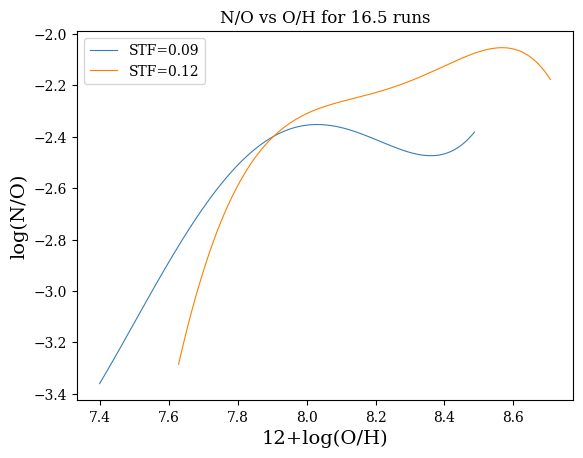

In [55]:
def plot_NO_OH_multi(file_paths, labels, title, filename):
    """
    Plots N/O vs O/H for multiple simulation files on one plot.
    file_paths: list of file paths to simulation results
    labels: list of labels for each line
    """
    plt.rc('font', family='serif')

    colors = ['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00']  # Extend if needed

    for i, path in enumerate(file_paths):
        data = load_data_with_names(path)
        logNO, logOH = data['Gas [N/O]:'], data['Gas [O/H]:']
        logNO, logOH = recalculate(logNO, logOH)
        smooth_logOH, smooth_logNO = fit(logOH, logNO)
        plt.plot(
            smooth_logOH, smooth_logNO,
            color=colors[i % len(colors)],
            lw=0.8,
            label=labels[i] if labels else f"Run {i+1}"
        )

    plt.xlabel('12+log(O/H)', fontsize=14)
    plt.ylabel('log(N/O)', fontsize=14)
    plt.title(title, fontsize=12)
    plt.legend()
    plt.savefig(filename, dpi=300)
    plt.show()

# Example usage:
file_paths = [
    "./simulation_results_from_galaxy_evol/16.5/imfKroupaSTF0.09alpha1.55Log_SFR1.0SFEN10Z_0-4.15/chemical_and_SN_evolution.txt",
    "./simulation_results_from_galaxy_evol/16.5/imfKroupaSTF0.15alpha1.55Log_SFR1.0SFEN10Z_0-4.15/chemical_and_SN_evolution.txt",
    # ...add more paths as needed
]
labels = ['STF=0.09', 'STF=0.12']  # ...add more labels as needed

plot_NO_OH_multi(
    file_paths,
    labels,
    title='N/O vs O/H for 16.5 runs',
    filename='NO_OH_16.5.png')

In [4]:
# save data to variable and recalculate axes

# outflow=100
# pathstf009out = "./simulation_results_from_galaxy_evol/imfKroupaSTF0.09alpha1.55SFR0.1SFEN0.66Z_0-4.15outflow100/chemical_and_SN_evolution.txt"
# pathstf012out = "./simulation_results_from_galaxy_evol/imfKroupaSTF0.12alpha1.55SFR0.1SFEN0.66Z_0-4.15outflow100/chemical_and_SN_evolution.txt"
# pathstf015out = "./simulation_results_from_galaxy_evol/imfKroupaSTF0.15alpha1.55SFR0.1SFEN0.66Z_0-4.15outflow100/chemical_and_SN_evolution.txt"
# pathstf018out = "./simulation_results_from_galaxy_evol/imfKroupaSTF0.18alpha1.55SFR0.1SFEN0.66Z_0-4.15outflow100/chemical_and_SN_evolution.txt"

# stf009out = load_data_with_names(pathstf009out)
# stf012out = load_data_with_names(pathstf012out)
# stf015out = load_data_with_names(pathstf015out)
# stf018out = load_data_with_names(pathstf018out)

# outflow=100
# logNOstf009out = stf009out['Gas [N/O]:']
# logOHstf009out = stf009out['Gas [O/H]:']
# logNOstf009out, logOHstf009out = recalculate(logNOstf009out, logOHstf009out)

# logNOstf012out = stf012out['Gas [N/O]:']
# logOHstf012out = stf012out['Gas [O/H]:']
# logNOstf012out, logOHstf012out = recalculate(logNOstf012out, logOHstf012out)

# logNOstf015out = stf015out['Gas [N/O]:']
# logOHstf015out = stf015out['Gas [O/H]:']
# logNOstf015out, logOHstf015out = recalculate(logNOstf015out, logOHstf015out)

# logNOstf018out = stf018out['Gas [N/O]:']
# logOHstf018out = stf018out['Gas [O/H]:']
# logNOstf018out, logOHstf018out = recalculate(logNOstf018out, logOHstf018out)

In [5]:
#plot sfh
#time = np.linspace(0, max(timestep), sfh.size)/1e9

# plt.rc('font', family='serif')
# plt.figure(figsize=(8, 6))
# plt.plot(time, sfh, color='k', lw=0.8)
# plt.xlabel('Time (Gyr)', fontsize=14)
# plt.ylabel('SFR (M$_\odot$ yr$^{-1}$)', fontsize=14)
# plt.title('Star Formation History', fontsize=16)

In [6]:
# plot log(C/O)-12+log(O/H)

# plt.rc('font', family='serif')
# plt.figure(figsize=(8, 6))
# logCOrec = [i + 0.26 for i in logNO]
# plt.plot(logOHrec[3:], logCOrec[3:], color='k', lw=0.8, label='recalculated')
# plt.xlabel('12+log(O/H)', fontsize=14)
# plt.ylabel('log(C/O)', fontsize=14)
# plt.legend()
# plt.savefig('logOH_logNO_recalculated.png', dpi=300)

Model M1

Kobayashi yields

Plots for $\alpha=1.15$

['./simulation_results_from_galaxy_evol/imfKroupaSTF0.09alpha1.55Log_SFR1.2SFEN20Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/imfKroupaSTF0.12alpha1.55Log_SFR1.2SFEN20Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/imfKroupaSTF0.15alpha1.55Log_SFR1.2SFEN20Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/imfKroupaSTF0.18alpha1.55Log_SFR1.2SFEN20Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/imfKroupaSTF0.24alpha1.55Log_SFR1.2SFEN20Z_0-4.15/chemical_and_SN_evolution.txt']


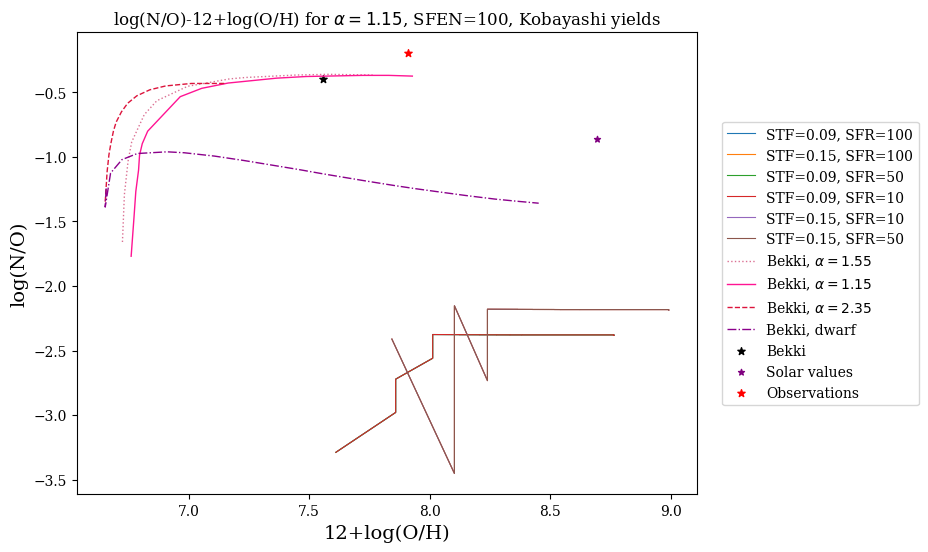

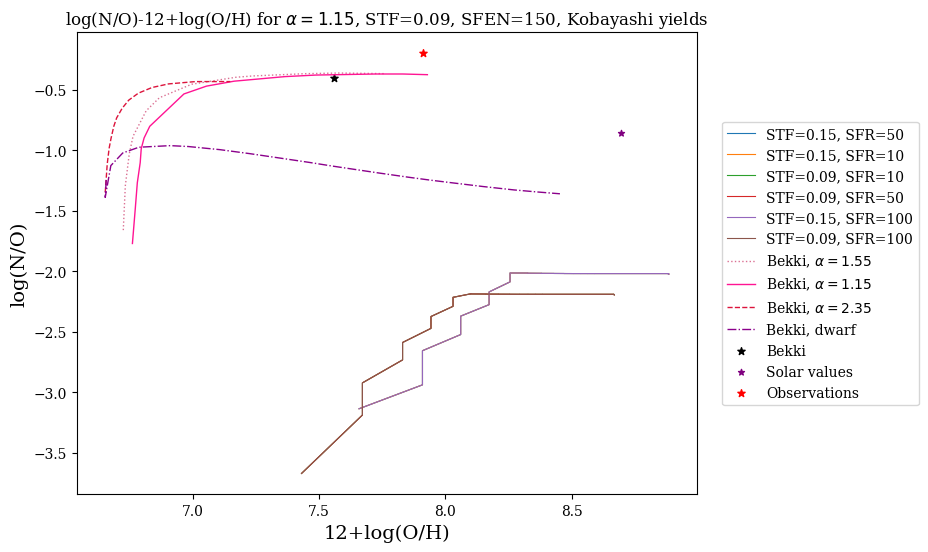

In [60]:
file_paths = glob.glob("./simulation_results_from_galaxy_evol/16.5/imfKroupaSTF*alpha1.15Log_SFR*SFEN10Z_0-4.15/chemical_and_SN_evolution.txt")
labels = ['STF=0.09, SFR=100', 'STF=0.15, SFR=100', 'STF=0.09, SFR=50', 'STF=0.09, SFR=10', 'STF=0.15, SFR=10', 'STF=0.15, SFR=50']
print(paths)
plot_NO_OH_comparison(
    file_paths,
    labels=labels,
    index_x=7,
    index_y=7000,
    title='log(N/O)-12+log(O/H) for $\\alpha=1.15$, SFEN=100, Kobayashi yields',
    filename='./figs/galevo/NO_OH_alpha=1.15_SFEN=100_Kob.png',
    evolution_track_difference=False
)

file_paths = glob.glob("./simulation_results_from_galaxy_evol/16.5/imfKroupaSTF*alpha1.15Log_SFR*SFEN15Z_0-4.15/chemical_and_SN_evolution.txt")
labels = ['STF=0.15, SFR=50', 'STF=0.15, SFR=10', 'STF=0.09, SFR=10', 'STF=0.09, SFR=50', 'STF=0.15, SFR=100', 'STF=0.09, SFR=100']
plot_NO_OH_comparison(
    file_paths,
    labels=labels,
    index_x=7,
    index_y=7000,
    title='log(N/O)-12+log(O/H) for $\\alpha=1.15$, STF=0.09, SFEN=150, Kobayashi yields',
    filename='./figs/galevo/NO_OH_alpha=1.15_SFEN=150_Kob.png',
    evolution_track_difference=False
)

Plots for $\alpha=1.55$

['./simulation_results_from_galaxy_evol/16.5/imfKroupaSTF0.09alpha1.55Log_SFR2.0SFEN10Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/16.5/imfKroupaSTF0.15alpha1.55Log_SFR2.0SFEN10Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/16.5/imfKroupaSTF0.09alpha1.55Log_SFR1.7SFEN10Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/16.5/imfKroupaSTF0.09alpha1.55Log_SFR1.0SFEN10Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/16.5/imfKroupaSTF0.15alpha1.55Log_SFR1.0SFEN10Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/16.5/imfKroupaSTF0.15alpha1.55Log_SFR1.7SFEN10Z_0-4.15/chemical_and_SN_evolution.txt']


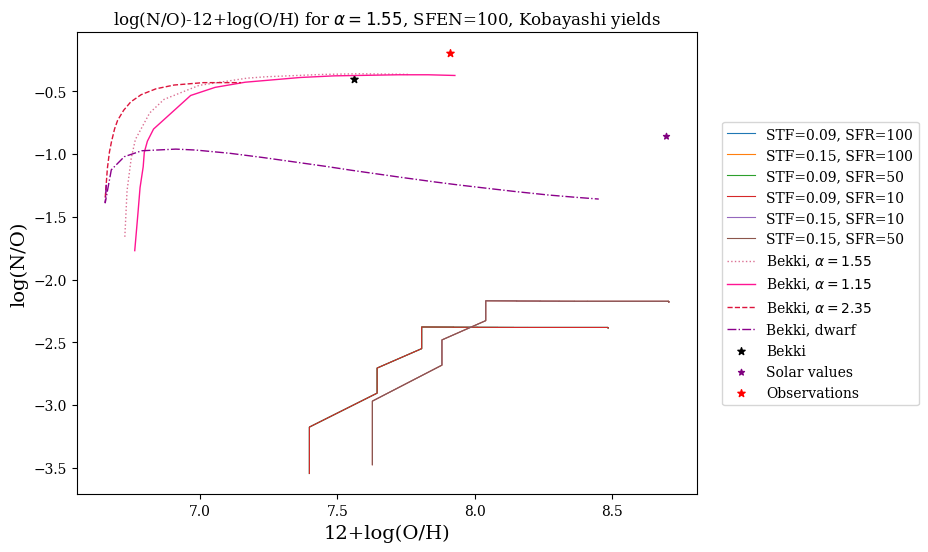

['./simulation_results_from_galaxy_evol/16.5/imfKroupaSTF0.15alpha1.55Log_SFR1.7SFEN15Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/16.5/imfKroupaSTF0.15alpha1.55Log_SFR1.0SFEN15Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/16.5/imfKroupaSTF0.09alpha1.55Log_SFR1.0SFEN15Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/16.5/imfKroupaSTF0.09alpha1.55Log_SFR1.7SFEN15Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/16.5/imfKroupaSTF0.15alpha1.55Log_SFR2.0SFEN15Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/16.5/imfKroupaSTF0.09alpha1.55Log_SFR2.0SFEN15Z_0-4.15/chemical_and_SN_evolution.txt']


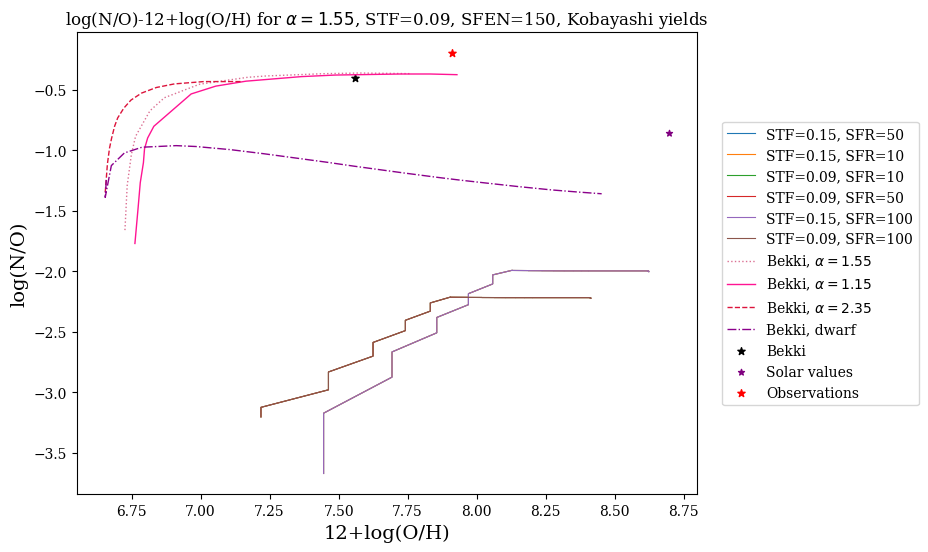

In [ ]:
file_paths = glob.glob("./simulation_results_from_galaxy_evol/16.5/imfKroupaSTF*alpha1.55Log_SFR*SFEN10Z_0-4.15/chemical_and_SN_evolution.txt")
print(file_paths)
labels = ['STF=0.09, SFR=100', 'STF=0.15, SFR=100', 'STF=0.09, SFR=50', 'STF=0.09, SFR=10', 'STF=0.15, SFR=10', 'STF=0.15, SFR=50']
plot_NO_OH_comparison(
    file_paths,
    labels=labels,
    index_x=6,
    index_y=7000,
    title='log(N/O)-12+log(O/H) for $\\alpha=1.55$, SFEN=100, Kobayashi yields',
    filename='./figs/galevo/NO_OH_alpha=1.55_SFEN=100_Kob.png',
    evolution_track_difference=False
)

file_paths = glob.glob("./simulation_results_from_galaxy_evol/16.5/imfKroupaSTF*alpha1.55Log_SFR*SFEN15Z_0-4.15/chemical_and_SN_evolution.txt")
print(file_paths)
labels = ['STF=0.15, SFR=50', 'STF=0.15, SFR=10', 'STF=0.09, SFR=10', 'STF=0.09, SFR=50', 'STF=0.15, SFR=100', 'STF=0.09, SFR=100']
plot_NO_OH_comparison(
    file_paths,
    labels=labels,
    index_x=6,
    index_y=7000,
    title='log(N/O)-12+log(O/H) for $\\alpha=1.55$, STF=0.09, SFEN=150, Kobayashi yields',
    filename='./figs/galevo/NO_OH_alpha=1.55_SFEN=150_Kob.png',
    evolution_track_difference=False
)


Plots for $\alpha=2.35$

['./simulation_results_from_galaxy_evol/16.5/imfKroupaSTF0.15alpha2.35Log_SFR2.0SFEN10Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/16.5/imfKroupaSTF0.09alpha2.35Log_SFR2.0SFEN10Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/16.5/imfKroupaSTF0.12alpha2.35Log_SFR2.0SFEN10Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/16.5/imfKroupaSTF0.24alpha2.35Log_SFR2.0SFEN10Z_0-4.15/chemical_and_SN_evolution.txt']


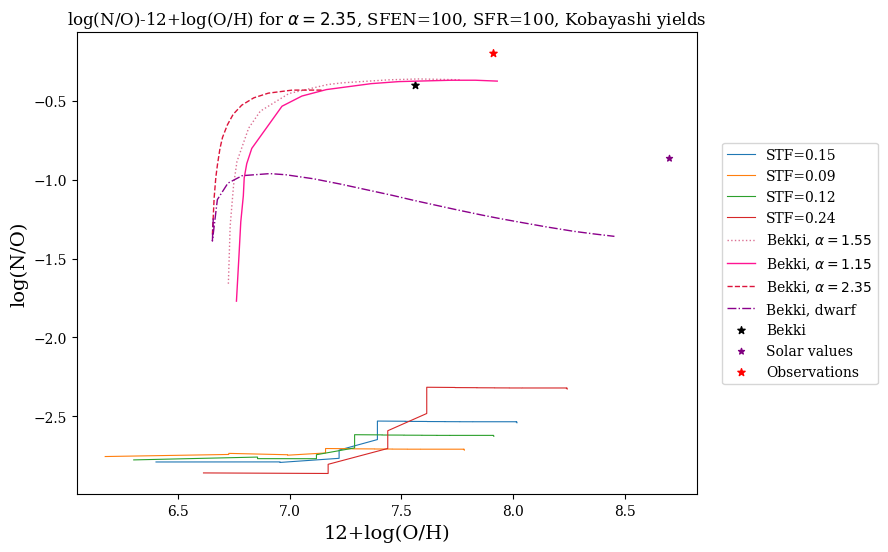

['./simulation_results_from_galaxy_evol/16.5/imfKroupaSTF0.24alpha2.35Log_SFR2.0SFEN15Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/16.5/imfKroupaSTF0.12alpha2.35Log_SFR2.0SFEN15Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/16.5/imfKroupaSTF0.09alpha2.35Log_SFR2.0SFEN15Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/16.5/imfKroupaSTF0.15alpha2.35Log_SFR2.0SFEN15Z_0-4.15/chemical_and_SN_evolution.txt']


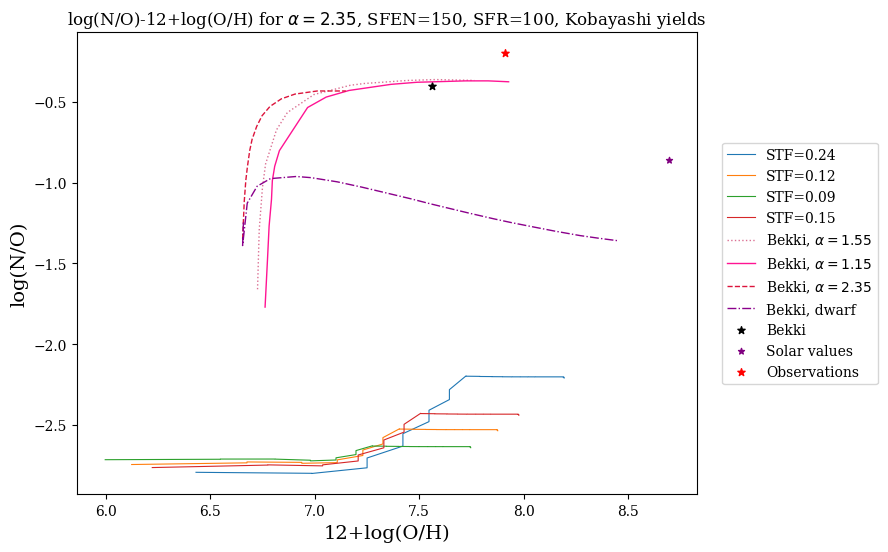

In [ ]:
file_paths = glob.glob("./simulation_results_from_galaxy_evol/16.5/imfKroupaSTF*alpha2.35Log_SFR2.0SFEN10Z_0-4.15/chemical_and_SN_evolution.txt")
print(file_paths)
labels = ['STF=0.15', 'STF=0.09', 'STF=0.12', 'STF=0.24']
plot_NO_OH_comparison(
    file_paths,
    labels=labels,
    index_x=5,
    index_y=7000,
    title='log(N/O)-12+log(O/H) for $\\alpha=2.35$, SFEN=100, SFR=100, Kobayashi yields',
    filename='./figs/galevo/NO_OH_alpha=2.35_SFEN=100_SFR=100_Kob.png',
    evolution_track_difference=False
)

file_paths = glob.glob("./simulation_results_from_galaxy_evol/16.5/imfKroupaSTF*alpha2.35Log_SFR2.0SFEN15Z_0-4.15/chemical_and_SN_evolution.txt")
print(file_paths)
labels = ['STF=0.24', 'STF=0.12', 'STF=0.09', 'STF=0.15']
plot_NO_OH_comparison(
    file_paths,
    labels=labels,
    index_x=5,
    index_y=7000,
    title='log(N/O)-12+log(O/H) for $\\alpha=2.35$, SFEN=150, SFR=100, Kobayashi yields',
    filename='./figs/galevo/NO_OH_alpha=2.35_SFEN=150_SFR=100_Kob.png',
    evolution_track_difference=False
)

Close-up for SFR=100

['./simulation_results_from_galaxy_evol/16.5/imfKroupaSTF0.15alpha1.15Log_SFR1.7SFEN15Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/16.5/imfKroupaSTF0.09alpha1.15Log_SFR1.7SFEN15Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/16.5/imfKroupaSTF0.09alpha1.15Log_SFR1.7SFEN10Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/16.5/imfKroupaSTF0.15alpha1.15Log_SFR1.7SFEN10Z_0-4.15/chemical_and_SN_evolution.txt']


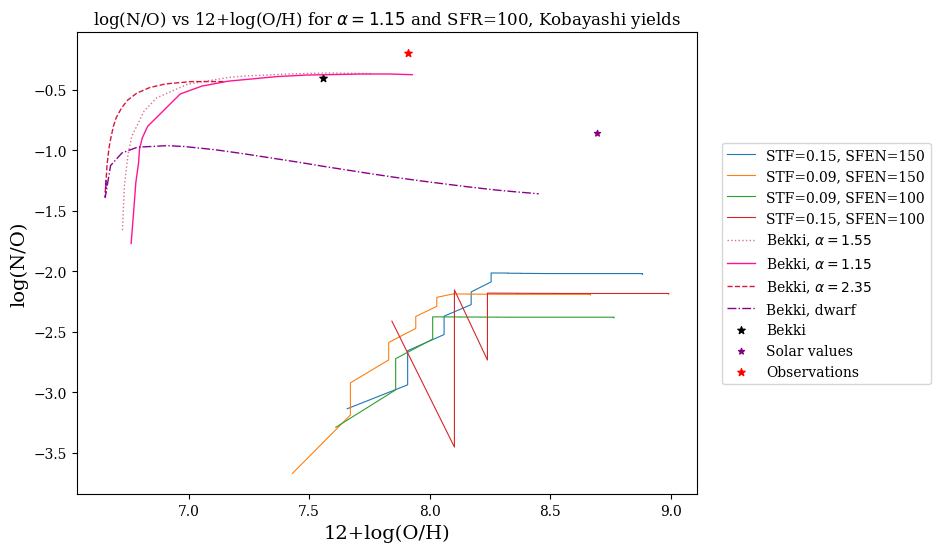

['./simulation_results_from_galaxy_evol/16.5/imfKroupaSTF0.15alpha1.55Log_SFR1.7SFEN15Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/16.5/imfKroupaSTF0.09alpha1.55Log_SFR1.7SFEN15Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/16.5/imfKroupaSTF0.09alpha1.55Log_SFR1.7SFEN10Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/16.5/imfKroupaSTF0.15alpha1.55Log_SFR1.7SFEN10Z_0-4.15/chemical_and_SN_evolution.txt']


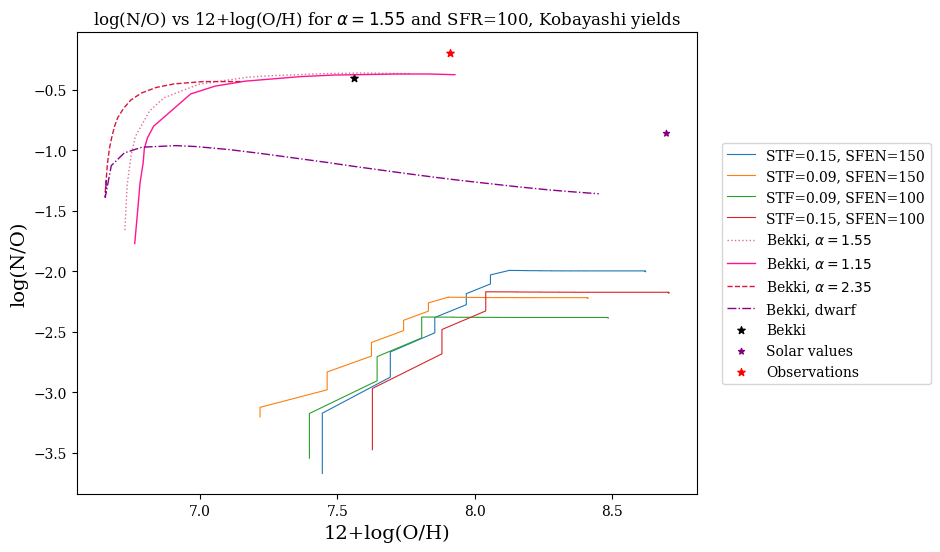

In [ ]:
file_paths = glob.glob("./simulation_results_from_galaxy_evol/16.5/imfKroupaSTF*alpha1.15Log_SFR1.7SFEN*Z_0-4.15/chemical_and_SN_evolution.txt")
print(file_paths)
labels = ['STF=0.15, SFEN=150', 'STF=0.09, SFEN=150', 'STF=0.09, SFEN=100', 'STF=0.15, SFEN=100']
plot_NO_OH_comparison(
    file_paths,
    labels=labels,
    index_x=7,
    index_y=1500,
    title='log(N/O) vs 12+log(O/H) for $\\alpha=1.15$ and SFR=100, Kobayashi yields',
    filename='./figs/galevo/NO_OH_alpha=1.15_SFR=100_Kob.png',
    evolution_track_difference=False
)

file_paths = glob.glob("./simulation_results_from_galaxy_evol/16.5/imfKroupaSTF*alpha1.55Log_SFR1.7SFEN*Z_0-4.15/chemical_and_SN_evolution.txt")
print(file_paths)
labels = ['STF=0.15, SFEN=150', 'STF=0.09, SFEN=150', 'STF=0.09, SFEN=100', 'STF=0.15, SFEN=100']
plot_NO_OH_comparison(
    file_paths,
    labels=labels,
    index_x=6,
    index_y=1500,
    title='log(N/O) vs 12+log(O/H) for $\\alpha=1.55$ and SFR=100, Kobayashi yields',
    filename='./figs/galevo/NO_OH_alpha=1.55_SFR=100_Kob.png',
    evolution_track_difference=False
)

Limongi yields

Plots for $\alpha=1.15$

['./simulation_results_from_galaxy_evol/20.5/imfKroupaSTF0.09alpha1.15Log_SFR2.0SFEN10Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/20.5/imfKroupaSTF0.15alpha1.15Log_SFR2.0SFEN10Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/20.5/imfKroupaSTF0.09alpha1.15Log_SFR1.7SFEN10Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/20.5/imfKroupaSTF0.09alpha1.15Log_SFR1.0SFEN10Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/20.5/imfKroupaSTF0.15alpha1.15Log_SFR1.0SFEN10Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/20.5/imfKroupaSTF0.15alpha1.15Log_SFR1.7SFEN10Z_0-4.15/chemical_and_SN_evolution.txt']


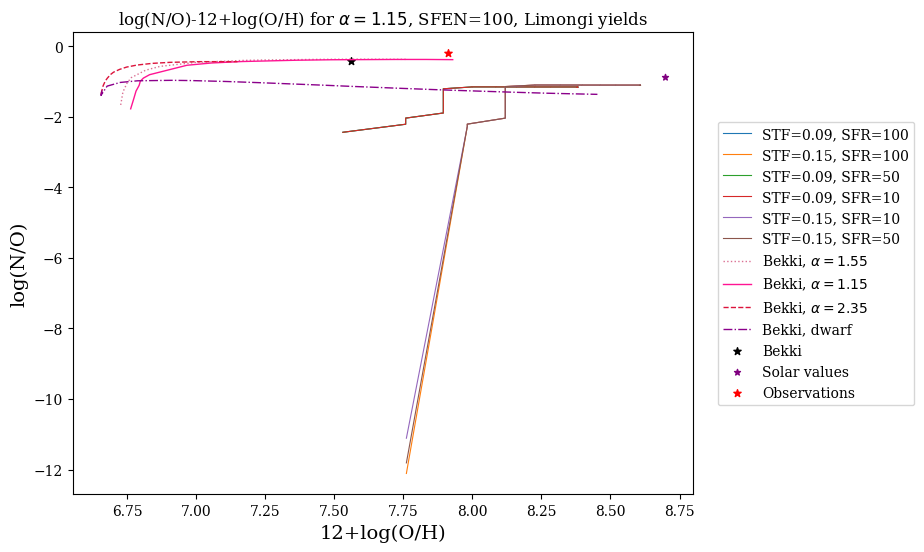

['./simulation_results_from_galaxy_evol/20.5/imfKroupaSTF0.15alpha1.15Log_SFR1.7SFEN15Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/20.5/imfKroupaSTF0.28alpha1.15Log_SFR1.2SFEN15Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/20.5/imfKroupaSTF0.15alpha1.15Log_SFR1.0SFEN15Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/20.5/imfKroupaSTF0.09alpha1.15Log_SFR1.0SFEN15Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/20.5/imfKroupaSTF0.09alpha1.15Log_SFR1.7SFEN15Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/20.5/imfKroupaSTF0.15alpha1.15Log_SFR2.0SFEN15Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/20.5/imfKroupaSTF0.09alpha1.15Log_SFR2.0SFEN15Z_0-4.15/chemical_and_SN_evolution.txt']


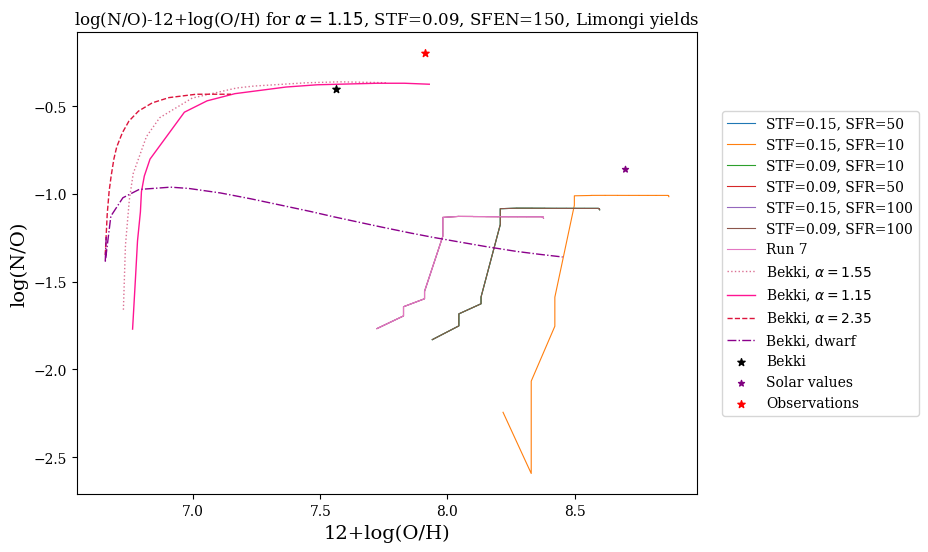

In [ ]:
file_paths = glob.glob("./simulation_results_from_galaxy_evol/20.5/imfKroupaSTF*alpha1.15Log_SFR*SFEN10Z_0-4.15/chemical_and_SN_evolution.txt")
print(file_paths)
labels = ['STF=0.09, SFR=100', 'STF=0.15, SFR=100', 'STF=0.09, SFR=50', 'STF=0.09, SFR=10', 'STF=0.15, SFR=10', 'STF=0.15, SFR=50']
plot_NO_OH_comparison(
    file_paths,
    labels=labels,
    index_x=7,
    index_y=7000,
    title='log(N/O)-12+log(O/H) for $\\alpha=1.15$, SFEN=100, Limongi yields',
    filename='./figs/galevo/NO_OH_alpha=1.15_SFEN=100_Lim.png',
    evolution_track_difference=False
)

file_paths = glob.glob("./simulation_results_from_galaxy_evol/20.5/imfKroupaSTF*alpha1.15Log_SFR*SFEN15Z_0-4.15/chemical_and_SN_evolution.txt")
print(file_paths)
labels = ['STF=0.15, SFR=50', 'STF=0.15, SFR=10', 'STF=0.09, SFR=10', 'STF=0.09, SFR=50', 'STF=0.15, SFR=100', 'STF=0.09, SFR=100']
plot_NO_OH_comparison(
    file_paths,
    labels=labels,
    index_x=11,
    index_y=7000,
    title='log(N/O)-12+log(O/H) for $\\alpha=1.15$, STF=0.09, SFEN=150, Limongi yields',
    filename='./figs/galevo/NO_OH_alpha=1.15_SFEN=150_Lim.png',
    evolution_track_difference=False
)

Plots for $\alpha=1.55$

['./simulation_results_from_galaxy_evol/20.5/imfKroupaSTF0.09alpha1.55Log_SFR2.0SFEN10Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/20.5/imfKroupaSTF0.15alpha1.55Log_SFR2.0SFEN10Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/20.5/imfKroupaSTF0.09alpha1.55Log_SFR1.7SFEN10Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/20.5/imfKroupaSTF0.09alpha1.55Log_SFR1.0SFEN10Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/20.5/imfKroupaSTF0.15alpha1.55Log_SFR1.0SFEN10Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/20.5/imfKroupaSTF0.15alpha1.55Log_SFR1.7SFEN10Z_0-4.15/chemical_and_SN_evolution.txt']


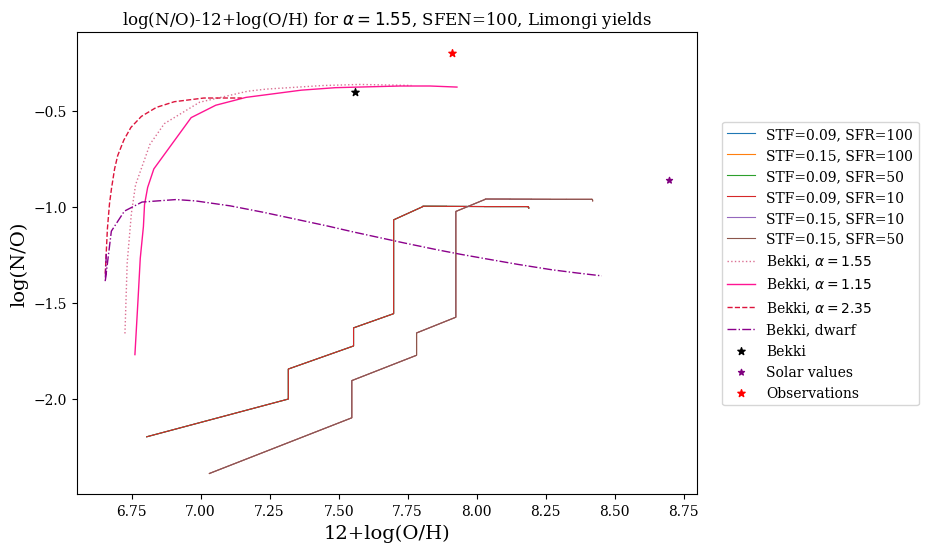

['./simulation_results_from_galaxy_evol/20.5/imfKroupaSTF0.15alpha1.55Log_SFR1.7SFEN15Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/20.5/imfKroupaSTF0.15alpha1.55Log_SFR1.0SFEN15Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/20.5/imfKroupaSTF0.09alpha1.55Log_SFR1.0SFEN15Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/20.5/imfKroupaSTF0.09alpha1.55Log_SFR1.7SFEN15Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/20.5/imfKroupaSTF0.15alpha1.55Log_SFR2.0SFEN15Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/20.5/imfKroupaSTF0.09alpha1.55Log_SFR2.0SFEN15Z_0-4.15/chemical_and_SN_evolution.txt']


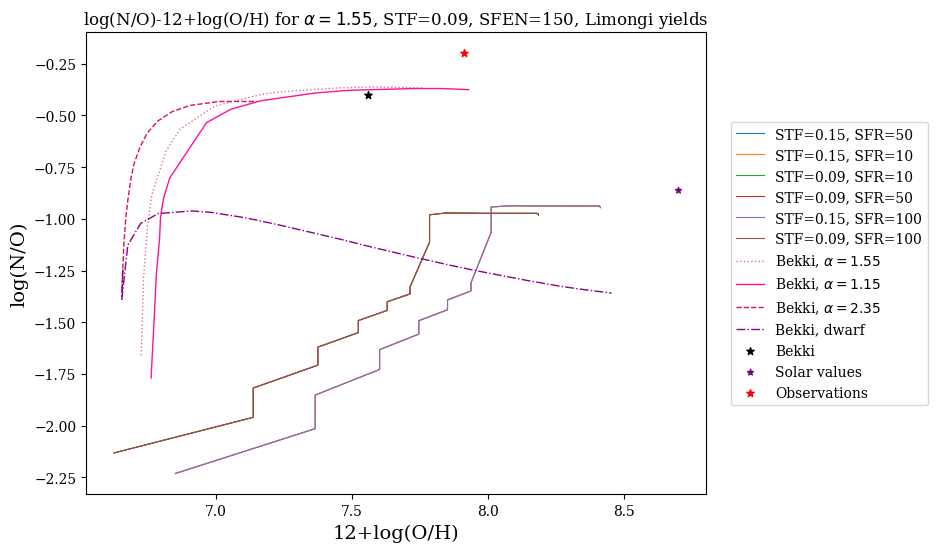

In [ ]:
file_paths = glob.glob("./simulation_results_from_galaxy_evol/20.5/imfKroupaSTF*alpha1.55Log_SFR*SFEN10Z_0-4.15/chemical_and_SN_evolution.txt")
print(file_paths)
labels = ['STF=0.09, SFR=100', 'STF=0.15, SFR=100', 'STF=0.09, SFR=50', 'STF=0.09, SFR=10', 'STF=0.15, SFR=10', 'STF=0.15, SFR=50']
plot_NO_OH_comparison(
    file_paths,
    labels=labels,
    index_x=5,
    index_y=7000,
    title='log(N/O)-12+log(O/H) for $\\alpha=1.55$, SFEN=100, Limongi yields',
    filename='./figs/galevo/NO_OH_alpha=1.55_SFEN=100_Lim.png',
    evolution_track_difference=False
)

file_paths = glob.glob("./simulation_results_from_galaxy_evol/20.5/imfKroupaSTF*alpha1.55Log_SFR*SFEN15Z_0-4.15/chemical_and_SN_evolution.txt")
print(file_paths)
labels = ['STF=0.15, SFR=50', 'STF=0.15, SFR=10', 'STF=0.09, SFR=10', 'STF=0.09, SFR=50', 'STF=0.15, SFR=100', 'STF=0.09, SFR=100']
plot_NO_OH_comparison(
    file_paths,
    labels=labels,
    index_x=5,
    index_y=7000,
    title='log(N/O)-12+log(O/H) for $\\alpha=1.55$, STF=0.09, SFEN=150, Limongi yields',
    filename='./figs/galevo/NO_OH_alpha=1.55_SFEN=150_Lim.png',
    evolution_track_difference=False
)

Plots for $\alpha=2.35$

['./simulation_results_from_galaxy_evol/20.5/imfKroupaSTF0.15alpha2.35Log_SFR2.0SFEN10Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/20.5/imfKroupaSTF0.09alpha2.35Log_SFR2.0SFEN10Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/20.5/imfKroupaSTF0.12alpha2.35Log_SFR2.0SFEN10Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/20.5/imfKroupaSTF0.18alpha2.35Log_SFR2.0SFEN10Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/20.5/imfKroupaSTF0.24alpha2.35Log_SFR2.0SFEN10Z_0-4.15/chemical_and_SN_evolution.txt']


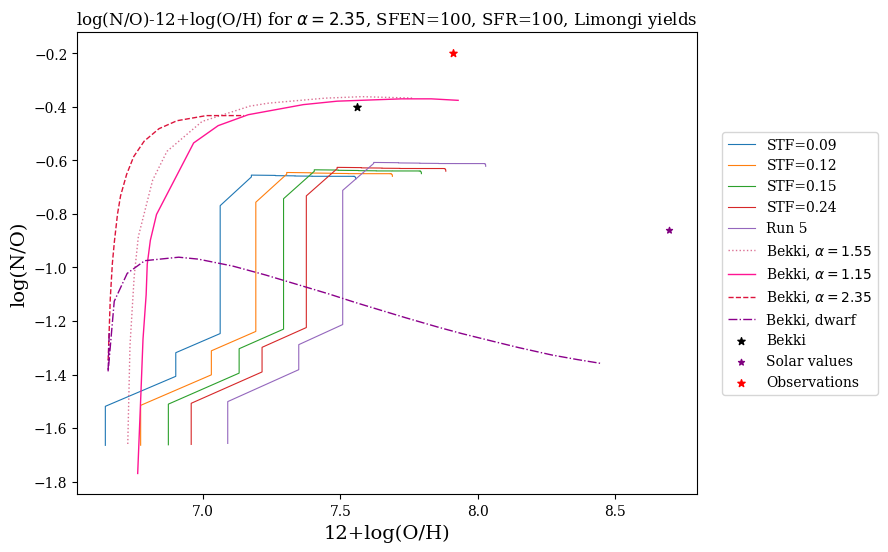

['./simulation_results_from_galaxy_evol/20.5/imfKroupaSTF0.09alpha2.35Log_SFR2.0SFEN15Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/20.5/imfKroupaSTF0.15alpha2.35Log_SFR2.0SFEN15Z_0-4.15/chemical_and_SN_evolution.txt']


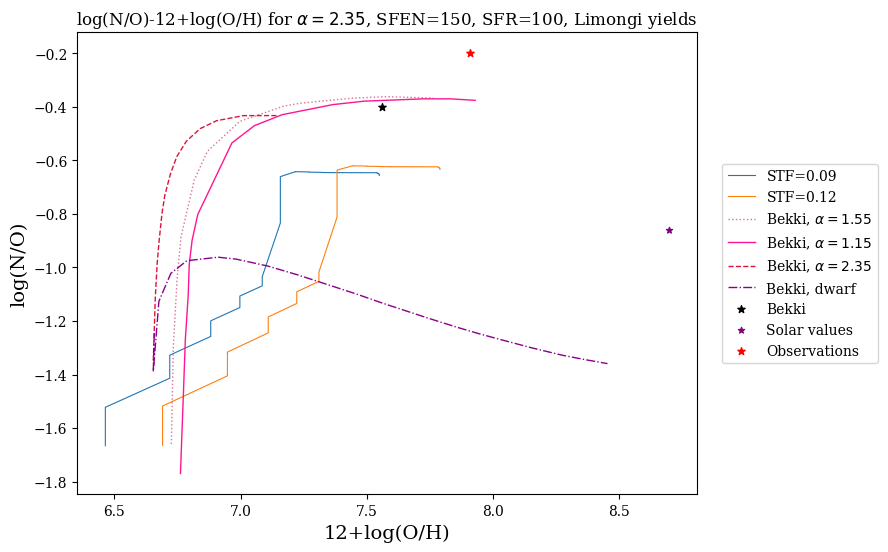

In [ ]:
file_paths = glob.glob("./simulation_results_from_galaxy_evol/20.5/imfKroupaSTF*alpha2.35Log_SFR2.0SFEN10Z_0-4.15/chemical_and_SN_evolution.txt")
print(file_paths)
file_paths.sort()
labels = ['STF=0.15', 'STF=0.09', 'STF=0.12', 'STF=0.24']
labels.sort()
plot_NO_OH_comparison(
    file_paths,
    labels=labels,
    index_x=6,
    index_y=7000,
    title='log(N/O)-12+log(O/H) for $\\alpha=2.35$, SFEN=100, SFR=100, Limongi yields',
    filename='./figs/galevo/NO_OH_alpha=2.35_SFEN=100_SFR=100_Lim.png',
    evolution_track_difference=False
)

file_paths = glob.glob("./simulation_results_from_galaxy_evol/20.5/imfKroupaSTF*alpha2.35Log_SFR2.0SFEN15Z_0-4.15/chemical_and_SN_evolution.txt")
print(file_paths)
file_paths.sort()
labels = ['STF=0.24', 'STF=0.12', 'STF=0.09', 'STF=0.15']
labels.sort()
plot_NO_OH_comparison(
    file_paths,
    labels=labels,
    index_x=6,
    index_y=7000,
    title='log(N/O)-12+log(O/H) for $\\alpha=2.35$, SFEN=150, SFR=100, Limongi yields',
    filename='./figs/galevo/NO_OH_alpha=2.35_SFEN=150_SFR=100_Lim.png',
    evolution_track_difference=False
)

['./simulation_results_from_galaxy_evol/20.5/imfKroupaSTF0.09alpha1.55Log_SFR2.0SFEN10Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/20.5/imfKroupaSTF0.09alpha1.15Log_SFR2.0SFEN10Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/20.5/imfKroupaSTF0.09alpha2.35Log_SFR2.0SFEN10Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/20.5/imfKroupaSTF0.09alpha2.35Log_SFR2.0SFEN15Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/20.5/imfKroupaSTF0.09alpha1.15Log_SFR2.0SFEN15Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/20.5/imfKroupaSTF0.09alpha1.55Log_SFR2.0SFEN15Z_0-4.15/chemical_and_SN_evolution.txt']


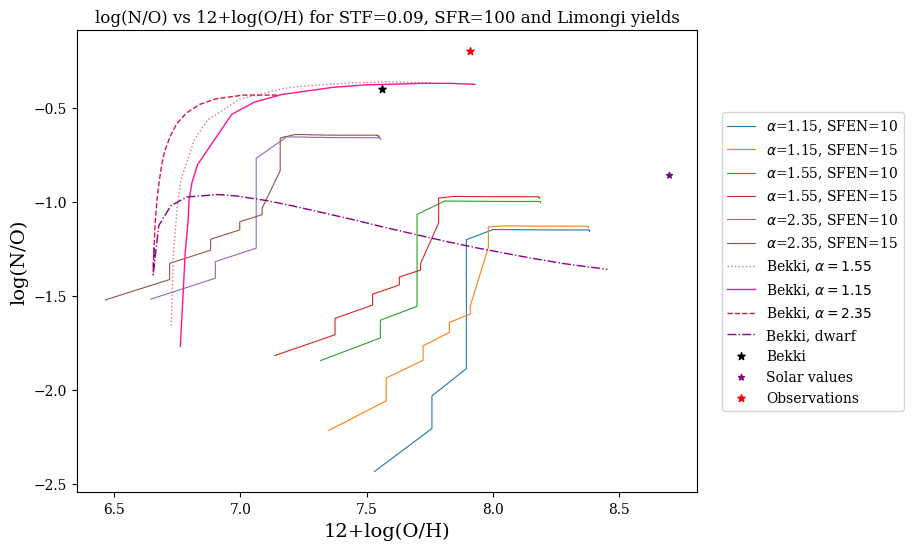

In [ ]:
file_paths = glob.glob("./simulation_results_from_galaxy_evol/20.5/imfKroupaSTF0.09alpha*Log_SFR2.0SFEN*Z_0-4.15/chemical_and_SN_evolution.txt")
print(file_paths)
file_paths.sort()
labels = ['$\\alpha$=1.55, SFEN=10', '$\\alpha$=1.15, SFEN=10', '$\\alpha$=2.35, SFEN=10', '$\\alpha$=2.35, SFEN=15', '$\\alpha$=1.15, SFEN=15', '$\\alpha$=1.55, SFEN=15']
labels.sort()
plot_NO_OH_comparison(
    file_paths,
    labels=labels,
    index_x=7,
    index_y=90050,
    title='log(N/O) vs 12+log(O/H) for STF=0.09, SFR=100 and Limongi yields',
    filename='./figs/galevo/NO_OH_stf=0.09_sfr=100_Lim.png',
    evolution_track_difference=False
)

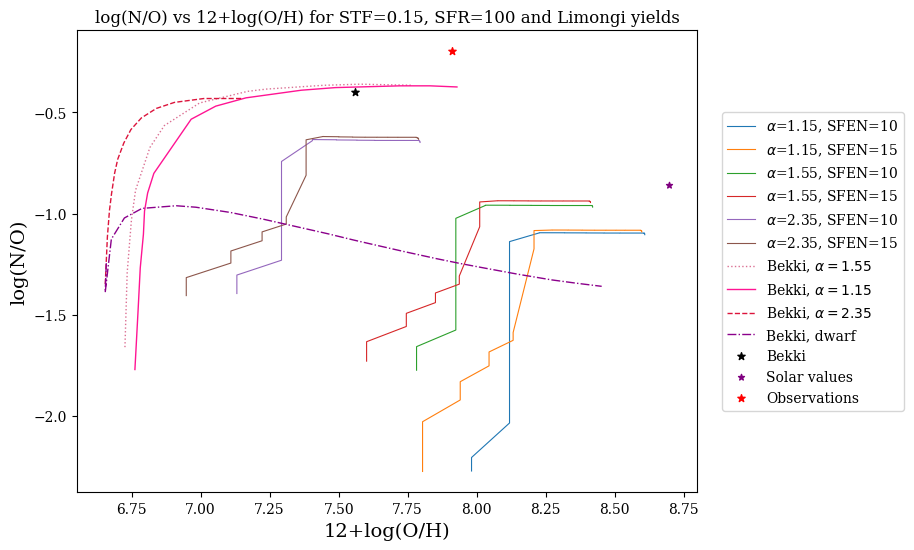

In [ ]:
file_paths = glob.glob("./simulation_results_from_galaxy_evol/20.5/imfKroupaSTF0.15alpha*Log_SFR2.0SFEN*Z_0-4.15/chemical_and_SN_evolution.txt")
file_paths.sort()
labels = ['$\\alpha$=2.35, SFEN=10', '$\\alpha$=1.55, SFEN=10', '$\\alpha$=1.15, SFEN=10', '$\\alpha$=1.15, SFEN=15', '$\\alpha$=1.55, SFEN=15', '$\\alpha$=2.35, SFEN=15']
labels.sort()
plot_NO_OH_comparison(
    file_paths,
    labels=labels,
    index_x=8,
    index_y=900,
    title='log(N/O) vs 12+log(O/H) for STF=0.15, SFR=100 and Limongi yields',
    filename='./figs/galevo/NO_OH_stf=0.15_sfr=100_Lim.png',
    evolution_track_difference=False
)
# repeat for steller_mass_upper_bound=1 (experiment, should look the same), repeat for steller_mass_upper_bound=100
# sfen = 5

['./simulation_results_from_galaxy_evol/21.5/imfKroupaSTF0.15alpha1.55Log_SFR1.3SFEN15Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/21.5/imfKroupaSTF0.12alpha1.55Log_SFR1.3SFEN15Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/21.5/imfKroupaSTF0.09alpha1.55Log_SFR1.3SFEN15Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/21.5/imfKroupaSTF0.18alpha1.55Log_SFR1.3SFEN15Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/21.5/imfKroupaSTF0.24alpha1.55Log_SFR1.3SFEN15Z_0-4.15/chemical_and_SN_evolution.txt']


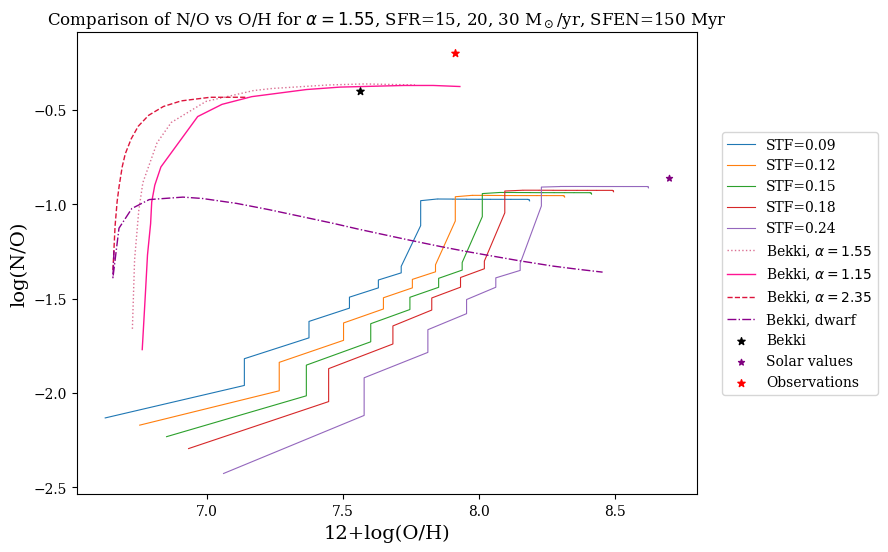

In [ ]:
paths=glob.glob("./simulation_results_from_galaxy_evol/21.5/imfKroupaSTF*alpha1.55Log_SFR1.3SFEN15Z_0-4.15/chemical_and_SN_evolution.txt")
print(paths)
paths.sort()
labels=['STF=0.24', 'STF=0.18', 'STF=0.12', 'STF=0.09', 'STF=0.15']
labels.sort()
plot_NO_OH_comparison(
    paths,
    labels,
    index_x=5,
    index_y=1000,
    title='Comparison of N/O vs O/H for $\\alpha=1.55$, SFR=15, 20, 30 M$_\odot$/yr, SFEN=150 Myr',
    filename='./figs/galevo/NO_OH_comparison_a=1,55_sfr=15_sfen=200_Lim.png',
    evolution_track_difference=False
)

['./simulation_results_from_galaxy_evol/20.5/imfKroupaSTF0.28alpha1.15Log_SFR1.2SFEN15Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/21.5/imfKroupaSTF0.09alpha1.15Log_SFR1.2SFEN15Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/21.5/imfKroupaSTF0.12alpha1.15Log_SFR1.2SFEN15Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/21.5/imfKroupaSTF0.15alpha1.15Log_SFR1.2SFEN15Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/21.5/imfKroupaSTF0.18alpha1.15Log_SFR1.2SFEN15Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/21.5/imfKroupaSTF0.24alpha1.15Log_SFR1.2SFEN15Z_0-4.15/chemical_and_SN_evolution.txt']


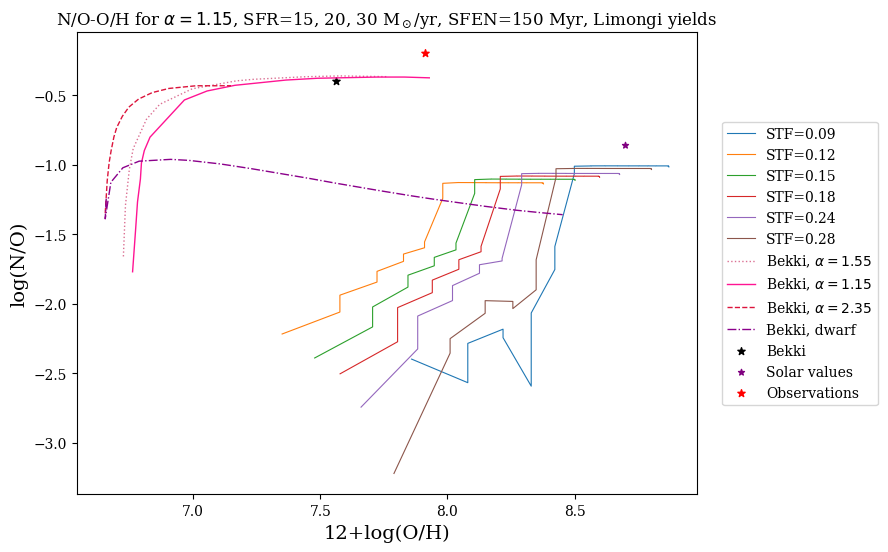

In [ ]:
paths=glob.glob("./simulation_results_from_galaxy_evol/21.5/imfKroupaSTF*alpha1.15Log_SFR1.2SFEN15Z_0-4.15/chemical_and_SN_evolution.txt")
paths += glob.glob("./simulation_results_from_galaxy_evol/20.5/imfKroupaSTF*alpha1.15Log_SFR1.2SFEN15Z_0-4.15/chemical_and_SN_evolution.txt")
paths.sort()
print(paths)
labels=['STF=0.24', 'STF=0.18', 'STF=0.12', 'STF=0.09', 'STF=0.15', 'STF=0.28', 'STF=0.36', 'STF=0.32']
labels.sort()
plot_NO_OH_comparison(
    paths,
    labels,
    index_x=7,
    index_y=1000,
    title='N/O-O/H for $\\alpha=1.15$, SFR=15, 20, 30 M$_\odot$/yr, SFEN=150 Myr, Limongi yields',
    filename='./figs/galevo/NO_OH_comparison_a=1,15_sfr=15_sfen=200_Lim.png',
    evolution_track_difference=False
)

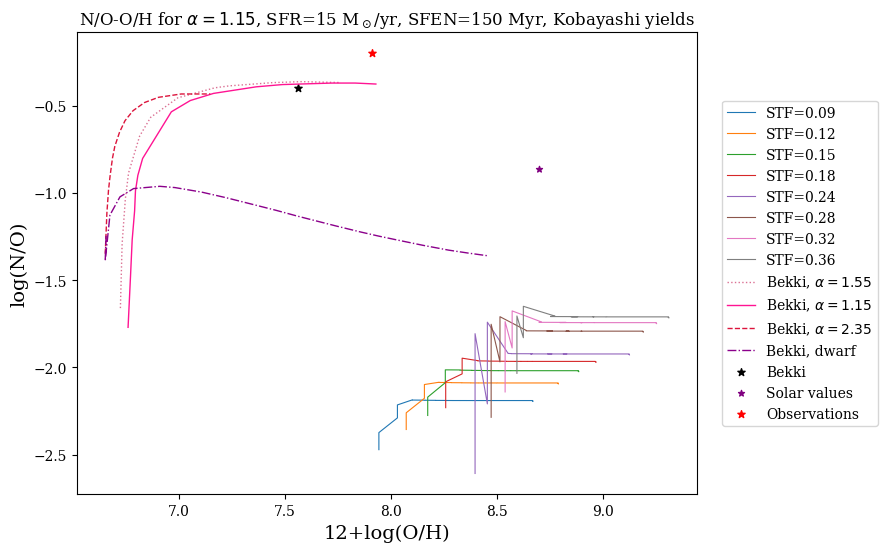

In [ ]:
paths=glob.glob("./simulation_results_from_galaxy_evol/19.5/imfKroupaSTF*alpha1.15Log_SFR1.2SFEN15Z_0-4.15/chemical_and_SN_evolution.txt")
paths.sort()
plot_NO_OH_comparison(
    paths,
    labels=['STF=0.09', 'STF=0.12', 'STF=0.15', 'STF=0.18', 'STF=0.24', 'STF=0.28', 'STF=0.32', 'STF=0.36'],
    index_x=12,
    index_y=1000,
    title='N/O-O/H for $\\alpha=1.15$, SFR=15 M$_\odot$/yr, SFEN=150 Myr, Kobayashi yields',
    filename='./figs/galevo/NO_OH_comparison_a=1,15_sfr=15_sfen=200_Kob.png',
    evolution_track_difference=False
)

['./simulation_results_from_galaxy_evol/21.5/imfKroupaSTF0.18alpha2.35Log_SFR1.2SFEN15Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/21.5/imfKroupaSTF0.24alpha2.35Log_SFR1.2SFEN15Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/21.5/imfKroupaSTF0.15alpha2.35Log_SFR1.2SFEN15Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/21.5/imfKroupaSTF0.09alpha2.35Log_SFR1.2SFEN15Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/21.5/imfKroupaSTF0.12alpha2.35Log_SFR1.2SFEN15Z_0-4.15/chemical_and_SN_evolution.txt']


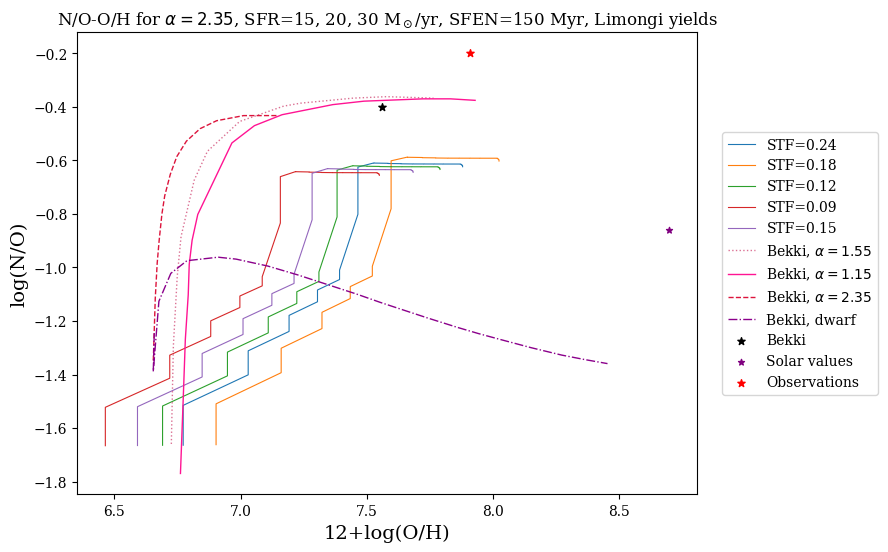

In [ ]:
paths=glob.glob("./simulation_results_from_galaxy_evol/21.5/imfKroupaSTF*alpha2.35Log_SFR1.2SFEN15Z_0-4.15/chemical_and_SN_evolution.txt")
print(paths)
plot_NO_OH_comparison(
    paths,
    labels=['STF=0.24', 'STF=0.18', 'STF=0.12', 'STF=0.09', 'STF=0.15'],
    index_x=6,
    index_y=1000,
    title='N/O-O/H for $\\alpha=2.35$, SFR=15, 20, 30 M$_\odot$/yr, SFEN=150 Myr, Limongi yields',
    filename='./figs/galevo/NO_OH_comparison_a=2.35_sfr=15_sfen=200_Lim.png',
    evolution_track_difference=False
)

Steller_mass_upper_bound=100

['./simulation_results_from_galaxy_evol/23.5/imfKroupaSTF0.09alpha1.15Log_SFR2.0SFEN10Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/23.5/imfKroupaSTF0.09alpha1.55Log_SFR2.0SFEN10Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/23.5/imfKroupaSTF0.09alpha2.35Log_SFR2.0SFEN10Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/23.5/imfKroupaSTF0.15alpha1.15Log_SFR2.0SFEN10Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/23.5/imfKroupaSTF0.15alpha1.55Log_SFR2.0SFEN10Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/23.5/imfKroupaSTF0.15alpha2.35Log_SFR2.0SFEN10Z_0-4.15/chemical_and_SN_evolution.txt']


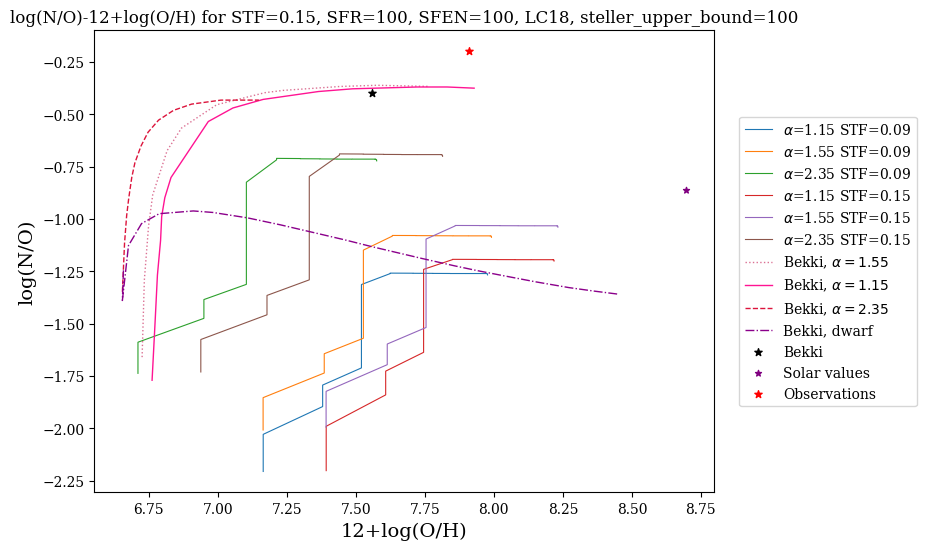

In [ ]:
file_paths = glob.glob("./simulation_results_from_galaxy_evol/23.5/imfKroupaSTF0.09alpha*Log_SFR2.0SFEN10Z_0-4.15/chemical_and_SN_evolution.txt")
file_paths += glob.glob("./simulation_results_from_galaxy_evol/23.5/imfKroupaSTF0.15alpha*Log_SFR2.0SFEN10Z_0-4.15/chemical_and_SN_evolution.txt")
file_paths.sort()
print(file_paths)
labels = ['$\\alpha$=1.15 STF=0.09', '$\\alpha$=1.55 STF=0.09', '$\\alpha$=2.35 STF=0.09', '$\\alpha$=1.15 STF=0.15', '$\\alpha$=1.55 STF=0.15', '$\\alpha$=2.35 STF=0.15']
plot_NO_OH_comparison(
    file_paths,
    labels=labels,
    index_x=6,
    index_y=900,
    title='log(N/O)-12+log(O/H) for STF=0.15, SFR=100, SFEN=100, LC18, steller_upper_bound=100',
    filename='./figs/galevo/NO_OH_stf=0.15_sfr=100_sfen=100_stel_up_bound=100_Lim.png',
    evolution_track_difference=False
)
# repeat for steller_mass_upper_bound=1 (experiment, should look the same), repeat for steller_mass_upper_bound=100
# sfen = 5

['./simulation_results_from_galaxy_evol/23.5/imfKroupaSTF0.15alpha1.15Log_SFR2.0SFEN5Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/23.5/imfKroupaSTF0.15alpha1.55Log_SFR2.0SFEN5Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/23.5/imfKroupaSTF0.15alpha2.35Log_SFR2.0SFEN5Z_0-4.15/chemical_and_SN_evolution.txt']


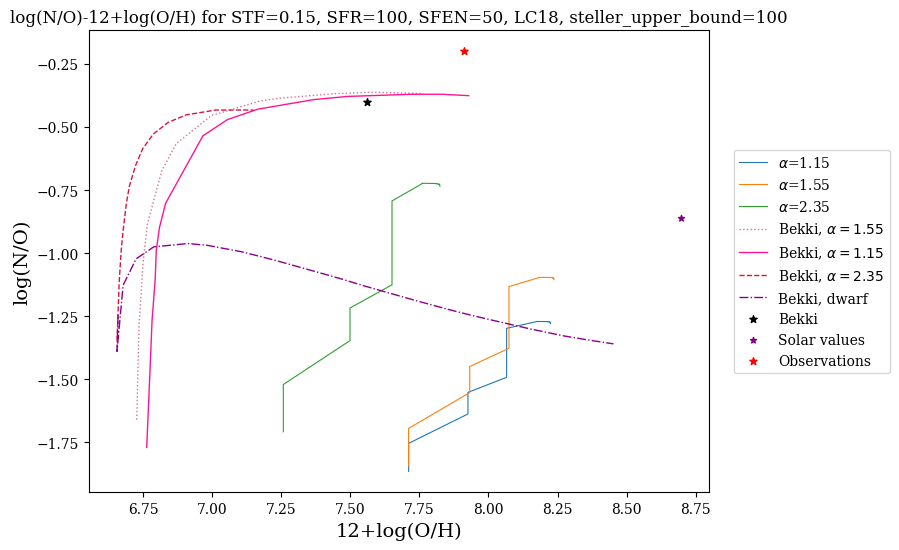

In [ ]:
file_paths = glob.glob("./simulation_results_from_galaxy_evol/23.5/imfKroupaSTF0.15alpha*Log_SFR2.0SFEN5Z_0-4.15/chemical_and_SN_evolution.txt")
file_paths.sort()
print(file_paths)
labels = ['$\\alpha$=1.15', '$\\alpha$=1.55', '$\\alpha$=2.35']
plot_NO_OH_comparison(
    file_paths,
    labels=labels,
    index_x=6,
    index_y=900,
    title='log(N/O)-12+log(O/H) for STF=0.15, SFR=100, SFEN=50, LC18, steller_upper_bound=100',
    filename='./figs/galevo/NO_OH_stf=0.15_sfr=100_sfen=50_stel_up_bound=100_Lim.png',
    evolution_track_difference=False
)
# repeat for steller_mass_upper_bound=1 (experiment, should look the same), repeat for steller_mass_upper_bound=100
# sfen = 5

['./simulation_results_from_galaxy_evol/23.5/imfKroupaSTF0.15alpha1.15Log_SFR2.0SFEN2.5Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/23.5/imfKroupaSTF0.15alpha1.15Log_SFR2.0SFEN5Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/23.5/imfKroupaSTF0.15alpha1.55Log_SFR2.0SFEN2.5Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/23.5/imfKroupaSTF0.15alpha1.55Log_SFR2.0SFEN5Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/23.5/imfKroupaSTF0.15alpha2.35Log_SFR2.0SFEN2.5Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/23.5/imfKroupaSTF0.15alpha2.35Log_SFR2.0SFEN5Z_0-4.15/chemical_and_SN_evolution.txt']


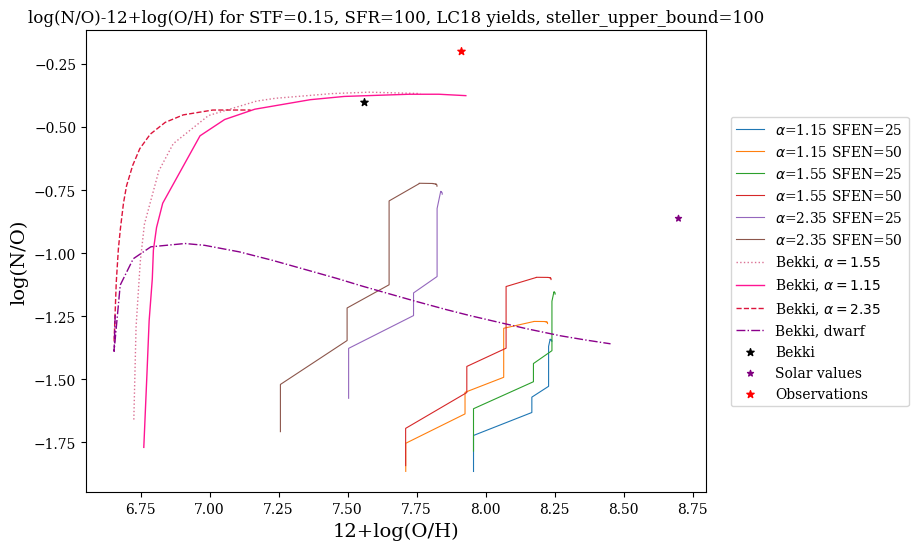

In [ ]:
file_paths = glob.glob("./simulation_results_from_galaxy_evol/23.5/imfKroupaSTF0.15alpha*Log_SFR2.0SFEN2.5Z_0-4.15/chemical_and_SN_evolution.txt")
file_paths += glob.glob("./simulation_results_from_galaxy_evol/23.5/imfKroupaSTF0.15alpha*Log_SFR2.0SFEN5Z_0-4.15/chemical_and_SN_evolution.txt")
file_paths.sort()
print(file_paths)
labels = ['$\\alpha$=1.15 SFEN=25', '$\\alpha$=1.15 SFEN=50', '$\\alpha$=1.55 SFEN=25', '$\\alpha$=1.55 SFEN=50', '$\\alpha$=2.35 SFEN=25', '$\\alpha$=2.35 SFEN=50']
plot_NO_OH_comparison(
    file_paths,
    labels=labels,
    index_x=6,
    index_y=900,
    title='log(N/O)-12+log(O/H) for STF=0.15, SFR=100, LC18 yields, steller_upper_bound=100',
    filename='./figs/galevo/NO_OH_stf=0.15_sfr=100_sfen=25_stel_up_bound=100_Lim.png',
    evolution_track_difference=False
)
# repeat for steller_mass_upper_bound=1 (experiment, should look the same), repeat for steller_mass_upper_bound=100
# sfen = 5

['./simulation_results_from_galaxy_evol/23.5/imfKroupaSTF0.09alpha1.15Log_SFR2.0SFEN2.5Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/23.5/imfKroupaSTF0.09alpha1.15Log_SFR2.0SFEN5Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/23.5/imfKroupaSTF0.09alpha1.55Log_SFR2.0SFEN2.5Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/23.5/imfKroupaSTF0.09alpha1.55Log_SFR2.0SFEN5Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/23.5/imfKroupaSTF0.09alpha2.35Log_SFR2.0SFEN2.5Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/23.5/imfKroupaSTF0.09alpha2.35Log_SFR2.0SFEN5Z_0-4.15/chemical_and_SN_evolution.txt']


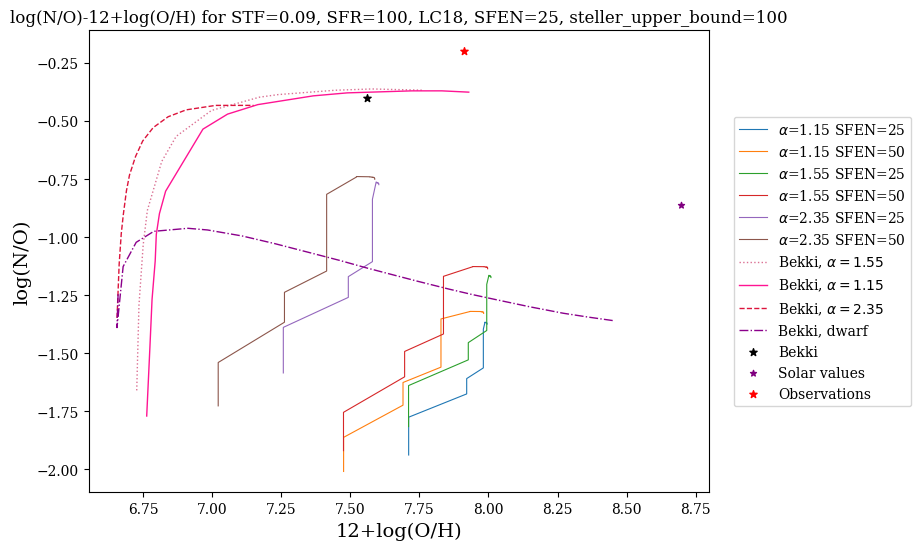

In [ ]:
file_paths = glob.glob("./simulation_results_from_galaxy_evol/23.5/imfKroupaSTF0.09alpha*Log_SFR2.0SFEN2.5Z_0-4.15/chemical_and_SN_evolution.txt")
file_paths += glob.glob("./simulation_results_from_galaxy_evol/23.5/imfKroupaSTF0.09alpha*Log_SFR2.0SFEN5Z_0-4.15/chemical_and_SN_evolution.txt")
file_paths.sort()
print(file_paths)
labels = ['$\\alpha$=1.15 SFEN=25', '$\\alpha$=1.15 SFEN=50', '$\\alpha$=1.55 SFEN=25', '$\\alpha$=1.55 SFEN=50', '$\\alpha$=2.35 SFEN=25', '$\\alpha$=2.35 SFEN=50']
plot_NO_OH_comparison(
    file_paths,
    labels=labels,
    index_x=6,
    index_y=900,
    title='log(N/O)-12+log(O/H) for STF=0.09, SFR=100, LC18, SFEN=25, steller_upper_bound=100',
    filename='./figs/galevo/NO_OH_stf=0.09_sfr=100_sfen=25_stel_up_bound=100_Lim.png',
    evolution_track_difference=False
)
# repeat for steller_mass_upper_bound=1 (experiment, should look the same), repeat for steller_mass_upper_bound=100
# sfen = 5

('simulation_results_from_galaxy_evol/16.5/imfKroupaSTF0.15alpha1.15Log_SFR2.0SFEN15Z_0-4.15/chemical_and_SN_evolution.txt', 'simulation_results_from_galaxy_evol/20.5/imfKroupaSTF0.15alpha1.55Log_SFR2.0SFEN15Z_0-4.15/chemical_and_SN_evolution.txt')


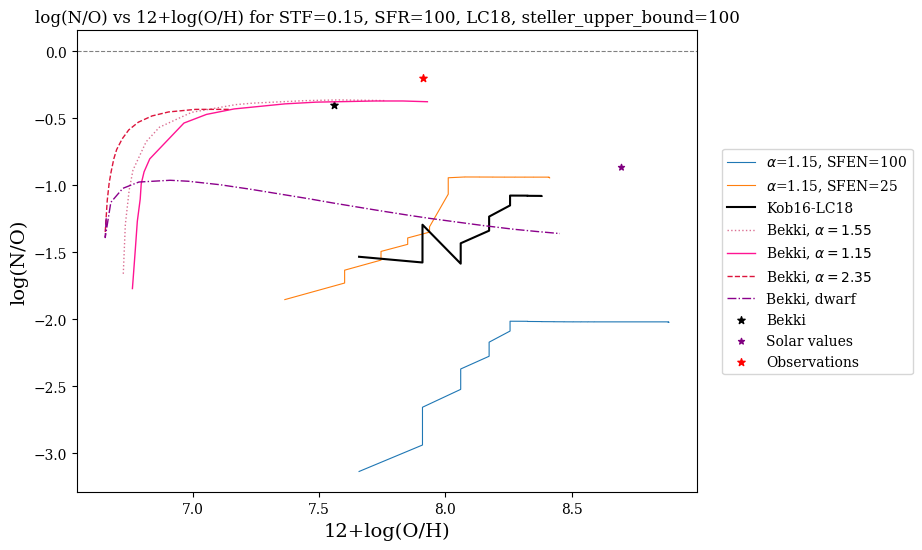

In [ ]:
file_paths = ("simulation_results_from_galaxy_evol/16.5/imfKroupaSTF0.15alpha1.15Log_SFR2.0SFEN15Z_0-4.15/chemical_and_SN_evolution.txt",
               "simulation_results_from_galaxy_evol/20.5/imfKroupaSTF0.15alpha1.55Log_SFR2.0SFEN15Z_0-4.15/chemical_and_SN_evolution.txt",)
print(file_paths)
labels = ['$\\alpha$=1.15, SFEN=100', '$\\alpha$=1.15, SFEN=25', '$\\alpha$=1.15, SFEN=50', '$\\alpha$=1.55, SFEN=100', '$\\alpha$=1.55, SFEN=25', '$\\alpha$=1.55, SFEN=50', '$\\alpha$=2.35, SFEN=100', '$\\alpha$=2.35, SFEN=25', '$\\alpha$=2.35, SFEN=50',]
plot_NO_OH_comparison(
    file_paths,
    labels=labels,
    index_x=7,
    index_y=52,
    title='log(N/O) vs 12+log(O/H) for STF=0.15, SFR=100, LC18, steller_upper_bound=100',
    filename='',
    evolution_track_difference=True
)
# repeat for steller_mass_upper_bound=1 (experiment, should look the same), repeat for steller_mass_upper_bound=100
# sfen = 5

['./simulation_results_from_galaxy_evol/24.5/imfKroupaSTF0.03alpha1.15Log_SFR2.0SFEN5Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/24.5/imfKroupaSTF0.03alpha1.55Log_SFR2.0SFEN5Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/24.5/imfKroupaSTF0.03alpha2.35Log_SFR2.0SFEN5Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/24.5/imfKroupaSTF0.05alpha1.15Log_SFR2.0SFEN5Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/24.5/imfKroupaSTF0.05alpha1.55Log_SFR2.0SFEN5Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/24.5/imfKroupaSTF0.05alpha2.35Log_SFR2.0SFEN5Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/24.5/imfKroupaSTF0.07alpha1.15Log_SFR2.0SFEN5Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/24.5/imfKroupaSTF0.07alpha1.55Log_SFR2.0SFEN5Z_0-4.15/chemical_and_SN_evolution.txt',

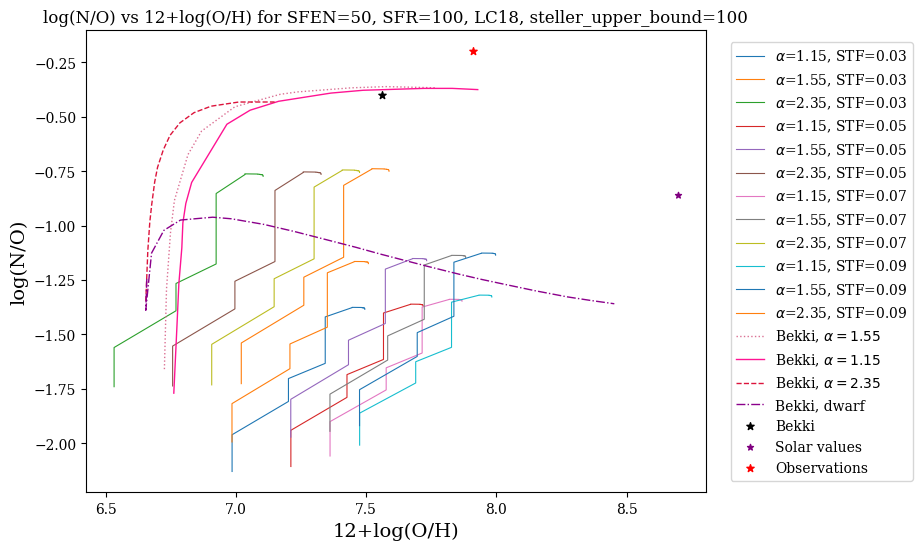

In [ ]:
file_paths = glob.glob("./simulation_results_from_galaxy_evol/24.5/imfKroupaSTF*alpha*Log_SFR2.0SFEN5Z_0-4.15/chemical_and_SN_evolution.txt")
file_paths.sort()
print(file_paths)
labels = ['$\\alpha$=1.15, STF=0.03', '$\\alpha$=1.55, STF=0.03', '$\\alpha$=2.35, STF=0.03', '$\\alpha$=1.15, STF=0.05', '$\\alpha$=1.55, STF=0.05', '$\\alpha$=2.35, STF=0.05', '$\\alpha$=1.15, STF=0.07', '$\\alpha$=1.55, STF=0.07', '$\\alpha$=2.35, STF=0.07', '$\\alpha$=1.15, STF=0.09', '$\\alpha$=1.55, STF=0.09', '$\\alpha$=2.35, STF=0.09',]
plot_NO_OH_comparison(
    file_paths,
    labels=labels,
    index_x=6,
    index_y=100,
    title='log(N/O) vs 12+log(O/H) for SFEN=50, SFR=100, LC18, steller_upper_bound=100',
    filename='./figs/galevo/NO_OH_sfr=100_sfen=50_stel_up_bound=100_Lim.png',
    evolution_track_difference=False
)

['./simulation_results_from_galaxy_evol/24.5/imfKroupaSTF0.03alpha1.15Log_SFR1.4SFEN2.5Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/24.5/imfKroupaSTF0.03alpha1.55Log_SFR1.4SFEN2.5Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/24.5/imfKroupaSTF0.03alpha2.35Log_SFR1.4SFEN2.5Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/24.5/imfKroupaSTF0.05alpha1.15Log_SFR1.4SFEN2.5Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/24.5/imfKroupaSTF0.05alpha1.55Log_SFR1.4SFEN2.5Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/24.5/imfKroupaSTF0.05alpha2.35Log_SFR1.4SFEN2.5Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/24.5/imfKroupaSTF0.07alpha1.15Log_SFR1.4SFEN2.5Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/24.5/imfKroupaSTF0.07alpha1.55Log_SFR1.4SFEN2.5Z_0-4.15/chemical_and_SN

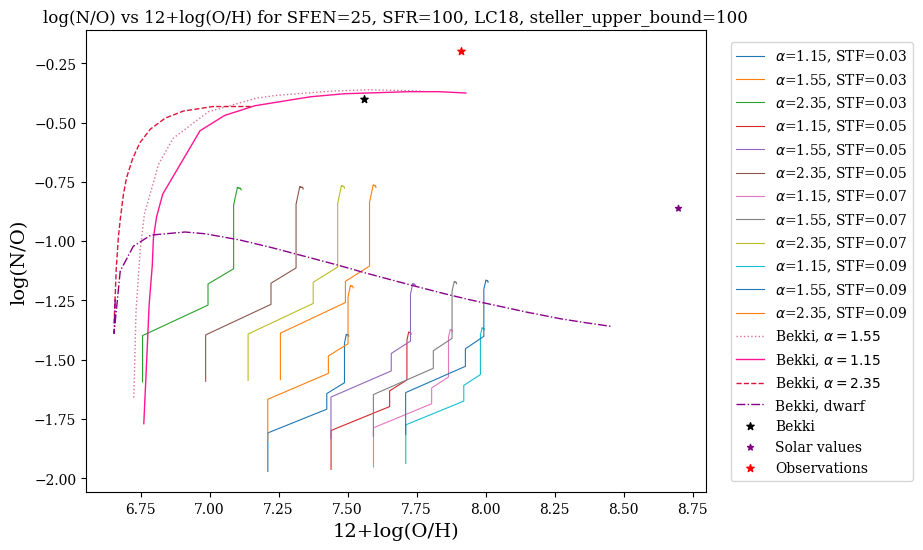

In [14]:
file_paths = glob.glob("./simulation_results_from_galaxy_evol/24.5/imfKroupaSTF*alpha*Log_SFR1.4SFEN2.5Z_0-4.15/chemical_and_SN_evolution.txt")
file_paths.sort()
print(file_paths)
labels = ['$\\alpha$=1.15, STF=0.03', '$\\alpha$=1.55, STF=0.03', '$\\alpha$=2.35, STF=0.03', '$\\alpha$=1.15, STF=0.05', '$\\alpha$=1.55, STF=0.05', '$\\alpha$=2.35, STF=0.05', '$\\alpha$=1.15, STF=0.07', '$\\alpha$=1.55, STF=0.07', '$\\alpha$=2.35, STF=0.07', '$\\alpha$=1.15, STF=0.09', '$\\alpha$=1.55, STF=0.09', '$\\alpha$=2.35, STF=0.09',]
plot_NO_OH_comparison(
    file_paths,
    labels=labels,
    index_x=6,
    index_y=100,
    title='log(N/O) vs 12+log(O/H) for SFEN=25, SFR=100, LC18, steller_upper_bound=100',
    filename='./figs/galevo/NO_OH_sfr=100_sfen=25_stel_up_bound=100_Lim.png',
    evolution_track_difference=False
)

['./simulation_results_from_galaxy_evol/27.5/imfKroupaSTF0.03alpha1.15Log_SFR2.0SFEN10Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/27.5/imfKroupaSTF0.03alpha1.55Log_SFR2.0SFEN10Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/27.5/imfKroupaSTF0.03alpha2.35Log_SFR2.0SFEN10Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/27.5/imfKroupaSTF0.05alpha1.15Log_SFR2.0SFEN10Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/27.5/imfKroupaSTF0.05alpha1.55Log_SFR2.0SFEN10Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/27.5/imfKroupaSTF0.05alpha2.35Log_SFR2.0SFEN10Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/27.5/imfKroupaSTF0.07alpha1.15Log_SFR2.0SFEN10Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/27.5/imfKroupaSTF0.07alpha1.55Log_SFR2.0SFEN10Z_0-4.15/chemical_and_SN_evoluti

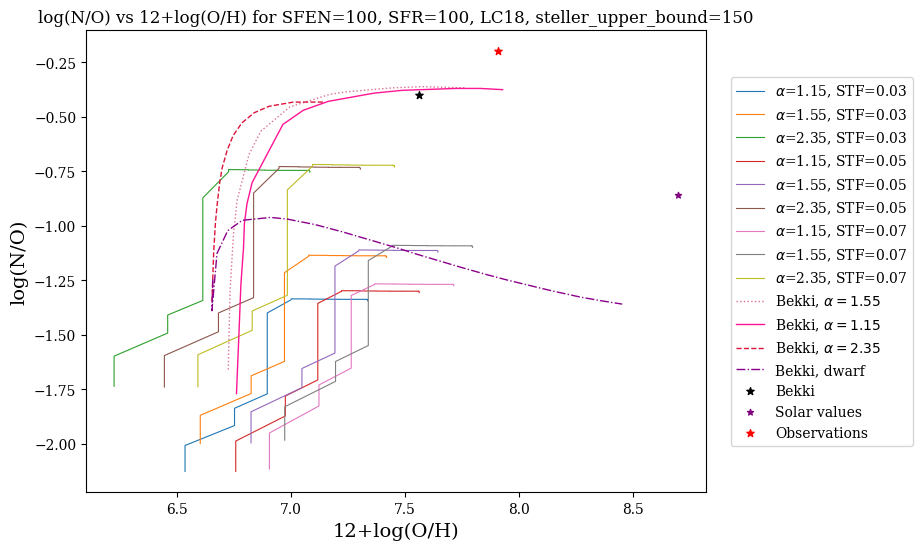

In [34]:
file_paths = glob.glob("./simulation_results_from_galaxy_evol/27.5/imfKroupaSTF0.03alpha*Log_SFR2.0SFEN10Z_0-4.15/chemical_and_SN_evolution.txt")
file_paths += glob.glob("./simulation_results_from_galaxy_evol/27.5/imfKroupaSTF0.05alpha*Log_SFR2.0SFEN10Z_0-4.15/chemical_and_SN_evolution.txt")
file_paths += glob.glob("./simulation_results_from_galaxy_evol/27.5/imfKroupaSTF0.07alpha*Log_SFR2.0SFEN10Z_0-4.15/chemical_and_SN_evolution.txt")
file_paths.sort()
print(file_paths)
labels = ['$\\alpha$=1.15, STF=0.03', '$\\alpha$=1.55, STF=0.03', '$\\alpha$=2.35, STF=0.03', '$\\alpha$=1.15, STF=0.05', '$\\alpha$=1.55, STF=0.05', '$\\alpha$=2.35, STF=0.05', '$\\alpha$=1.15, STF=0.07', '$\\alpha$=1.55, STF=0.07', '$\\alpha$=2.35, STF=0.07', '$\\alpha$=1.15, STF=0.09', '$\\alpha$=1.55, STF=0.09', '$\\alpha$=2.35, STF=0.09',]
plot_NO_OH_comparison(
    file_paths,
    labels=labels,
    index_x=6,
    index_y=100,
    title='log(N/O) vs 12+log(O/H) for SFEN=100, SFR=100, LC18, steller_upper_bound=150',
    filename='./figs/galevo/NO_OH_sfr=100_sfen=100_stel_up_bound=150_Lim.png',
    evolution_track_difference=False
)

['./simulation_results_from_galaxy_evol/27.5/imfKroupaSTF0.03alpha1.15Log_SFR2.0SFEN5Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/27.5/imfKroupaSTF0.03alpha1.55Log_SFR2.0SFEN5Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/27.5/imfKroupaSTF0.03alpha2.35Log_SFR2.0SFEN5Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/27.5/imfKroupaSTF0.05alpha1.15Log_SFR2.0SFEN5Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/27.5/imfKroupaSTF0.05alpha1.55Log_SFR2.0SFEN5Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/27.5/imfKroupaSTF0.05alpha2.35Log_SFR2.0SFEN5Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/27.5/imfKroupaSTF0.07alpha1.15Log_SFR2.0SFEN5Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/27.5/imfKroupaSTF0.07alpha1.55Log_SFR2.0SFEN5Z_0-4.15/chemical_and_SN_evolution.txt',

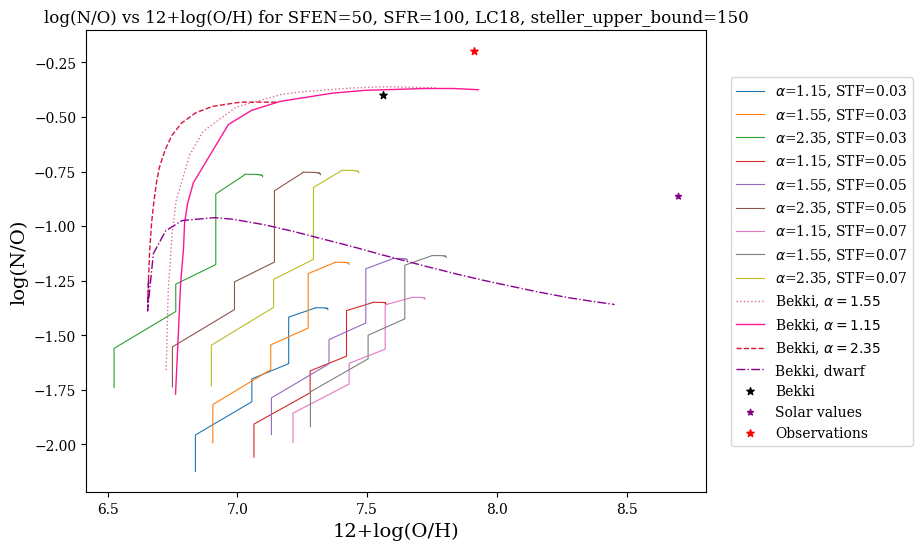

In [36]:
file_paths = glob.glob("./simulation_results_from_galaxy_evol/27.5/imfKroupaSTF0.03alpha*Log_SFR2.0SFEN5Z_0-4.15/chemical_and_SN_evolution.txt")
file_paths += glob.glob("./simulation_results_from_galaxy_evol/27.5/imfKroupaSTF0.05alpha*Log_SFR2.0SFEN5Z_0-4.15/chemical_and_SN_evolution.txt")
file_paths += glob.glob("./simulation_results_from_galaxy_evol/27.5/imfKroupaSTF0.07alpha*Log_SFR2.0SFEN5Z_0-4.15/chemical_and_SN_evolution.txt")
file_paths.sort()
print(file_paths)
labels = ['$\\alpha$=1.15, STF=0.03', '$\\alpha$=1.55, STF=0.03', '$\\alpha$=2.35, STF=0.03', '$\\alpha$=1.15, STF=0.05', '$\\alpha$=1.55, STF=0.05', '$\\alpha$=2.35, STF=0.05', '$\\alpha$=1.15, STF=0.07', '$\\alpha$=1.55, STF=0.07', '$\\alpha$=2.35, STF=0.07', '$\\alpha$=1.15, STF=0.09', '$\\alpha$=1.55, STF=0.09', '$\\alpha$=2.35, STF=0.09',]
plot_NO_OH_comparison(
    file_paths,
    labels=labels,
    index_x=6,
    index_y=100,
    title='log(N/O) vs 12+log(O/H) for SFEN=50, SFR=100, LC18, steller_upper_bound=150',
    filename='./figs/galevo/NO_OH_sfr=100_sfen=50_stel_up_bound=150_Lim.png',
    evolution_track_difference=False
)

['./simulation_results_from_galaxy_evol/27.5/imfKroupaSTF0.03alpha1.15Log_SFR2.0SFEN2.5Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/27.5/imfKroupaSTF0.03alpha1.55Log_SFR2.0SFEN2.5Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/27.5/imfKroupaSTF0.03alpha2.35Log_SFR2.0SFEN2.5Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/27.5/imfKroupaSTF0.05alpha1.15Log_SFR2.0SFEN2.5Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/27.5/imfKroupaSTF0.05alpha1.55Log_SFR2.0SFEN2.5Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/27.5/imfKroupaSTF0.05alpha2.35Log_SFR2.0SFEN2.5Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/27.5/imfKroupaSTF0.07alpha1.15Log_SFR2.0SFEN2.5Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/27.5/imfKroupaSTF0.07alpha1.55Log_SFR2.0SFEN2.5Z_0-4.15/chemical_and_SN

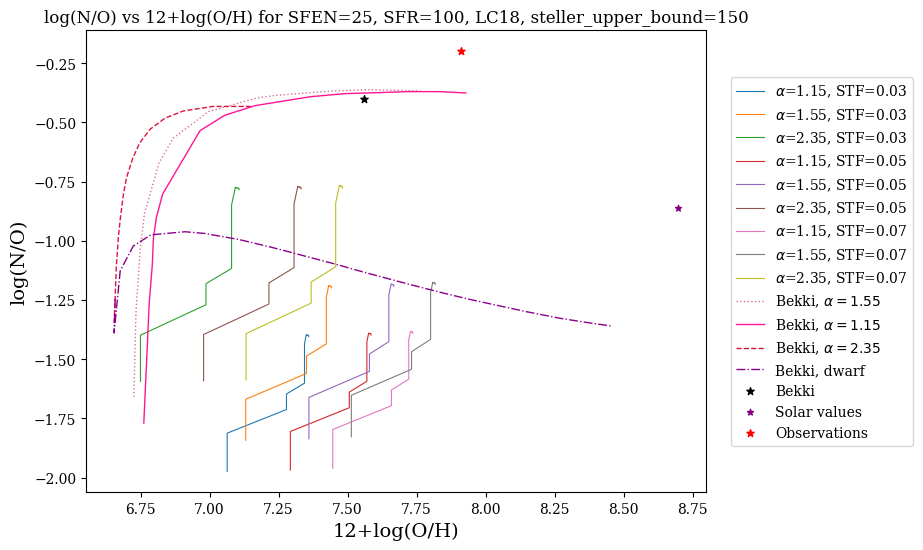

In [38]:
file_paths = glob.glob("./simulation_results_from_galaxy_evol/27.5/imfKroupaSTF0.03alpha*Log_SFR2.0SFEN2.5Z_0-4.15/chemical_and_SN_evolution.txt")
file_paths += glob.glob("./simulation_results_from_galaxy_evol/27.5/imfKroupaSTF0.05alpha*Log_SFR2.0SFEN2.5Z_0-4.15/chemical_and_SN_evolution.txt")
file_paths += glob.glob("./simulation_results_from_galaxy_evol/27.5/imfKroupaSTF0.07alpha*Log_SFR2.0SFEN2.5Z_0-4.15/chemical_and_SN_evolution.txt")
file_paths.sort()
print(file_paths)
labels = ['$\\alpha$=1.15, STF=0.03', '$\\alpha$=1.55, STF=0.03', '$\\alpha$=2.35, STF=0.03', '$\\alpha$=1.15, STF=0.05', '$\\alpha$=1.55, STF=0.05', '$\\alpha$=2.35, STF=0.05', '$\\alpha$=1.15, STF=0.07', '$\\alpha$=1.55, STF=0.07', '$\\alpha$=2.35, STF=0.07', '$\\alpha$=1.15, STF=0.09', '$\\alpha$=1.55, STF=0.09', '$\\alpha$=2.35, STF=0.09',]
plot_NO_OH_comparison(
    file_paths,
    labels=labels,
    index_x=6,
    index_y=100,
    title='log(N/O) vs 12+log(O/H) for SFEN=25, SFR=100, LC18, steller_upper_bound=150',
    filename='./figs/galevo/NO_OH_sfr=100_sfen=25_stel_up_bound=150_Lim.png',
    evolution_track_difference=False
)

./simulation_results_from_galaxy_evol/27.5/mod_sfh

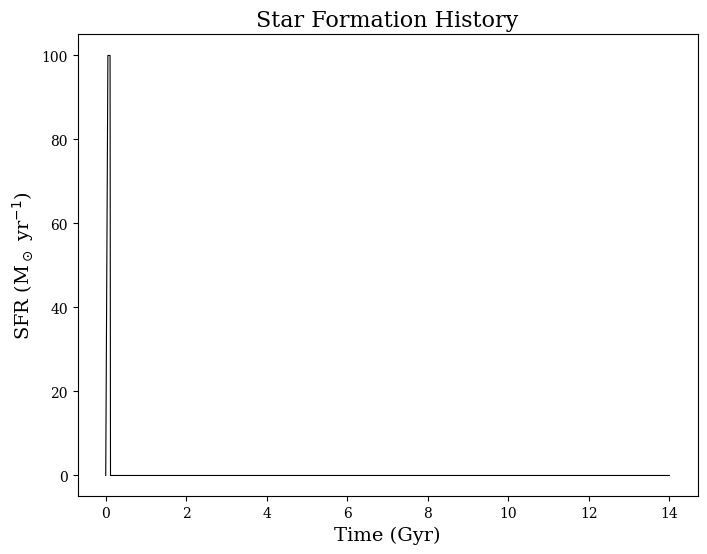

In [54]:
sfh_path = "./simulation_results_from_galaxy_evol/27.5/mod_SFH/SFH.txt"
sfh = np.loadtxt(sfh_path)

timestep_path = "./simulation_results_from_galaxy_evol/27.5/mod_SFH/imfKroupaSTF0.03alpha2.35Log_SFR2.0SFEN2.5Z_0-4.15/chemical_and_SN_evolution.txt"
data = load_data_with_names(timestep_path)
timestep = data['time step list:']
time = np.linspace(0, max(timestep), sfh.size)/1e9

plt.rc('font', family='serif')
plt.figure(figsize=(8, 6))
plt.plot(time, sfh, color='k', lw=0.8)
plt.xlabel('Time (Gyr)', fontsize=14)
plt.ylabel('SFR (M$_\odot$ yr$^{-1}$)', fontsize=14)
plt.title('Star Formation History', fontsize=16)
plt.savefig('./figs/galevo/27.5_mod_SFH.png')

['./simulation_results_from_galaxy_evol/27.5/mod_SFH/imfKroupaSTF0.03alpha1.15Log_SFR2.0SFEN2.5Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/27.5/mod_SFH/imfKroupaSTF0.03alpha1.55Log_SFR2.0SFEN2.5Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/27.5/mod_SFH/imfKroupaSTF0.03alpha2.35Log_SFR2.0SFEN2.5Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/27.5/mod_SFH/imfKroupaSTF0.05alpha1.15Log_SFR2.0SFEN2.5Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/27.5/mod_SFH/imfKroupaSTF0.05alpha1.55Log_SFR2.0SFEN2.5Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/27.5/mod_SFH/imfKroupaSTF0.05alpha2.35Log_SFR2.0SFEN2.5Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/27.5/mod_SFH/imfKroupaSTF0.07alpha1.15Log_SFR2.0SFEN2.5Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/27.5/mod_SFH/im

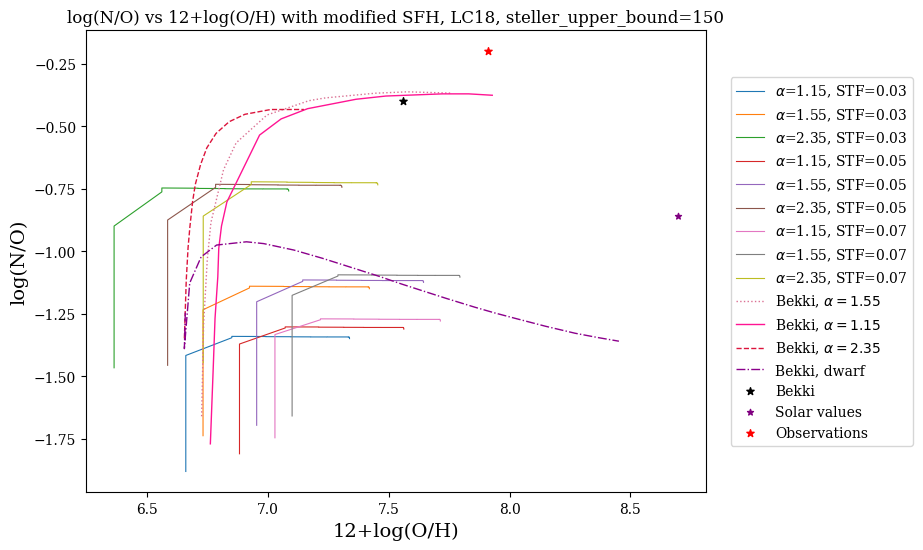

In [53]:
file_paths = glob.glob("./simulation_results_from_galaxy_evol/27.5/mod_SFH/imfKroupaSTF0.03alpha*Log_SFR2.0SFEN2.5Z_0-4.15/chemical_and_SN_evolution.txt")
file_paths += glob.glob("./simulation_results_from_galaxy_evol/27.5/mod_SFH/imfKroupaSTF0.05alpha*Log_SFR2.0SFEN2.5Z_0-4.15/chemical_and_SN_evolution.txt")
file_paths += glob.glob("./simulation_results_from_galaxy_evol/27.5/mod_SFH/imfKroupaSTF0.07alpha*Log_SFR2.0SFEN2.5Z_0-4.15/chemical_and_SN_evolution.txt")
file_paths.sort()
print(file_paths)
labels = ['$\\alpha$=1.15, STF=0.03', '$\\alpha$=1.55, STF=0.03', '$\\alpha$=2.35, STF=0.03', '$\\alpha$=1.15, STF=0.05', '$\\alpha$=1.55, STF=0.05', '$\\alpha$=2.35, STF=0.05', '$\\alpha$=1.15, STF=0.07', '$\\alpha$=1.55, STF=0.07', '$\\alpha$=2.35, STF=0.07', '$\\alpha$=1.15, STF=0.09', '$\\alpha$=1.55, STF=0.09', '$\\alpha$=2.35, STF=0.09',]
plot_NO_OH_comparison(
    file_paths,
    labels=labels,
    index_x=10,
    index_y=100,
    title='log(N/O) vs 12+log(O/H) with modified SFH, LC18, steller_upper_bound=150',
    filename='./figs/galevo/NO_OH_mod_sfh_stel_up_bound=150_Lim.png',
    evolution_track_difference=False
)

Experiments with SFH_model='gas_mass_dependent' model

['./simulation_results_from_galaxy_evol/28.5/imfKroupaSTF0.05alpha1.15Log_SFR2.0SFEN10Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/28.5/imfKroupaSTF0.05alpha1.55Log_SFR2.0SFEN10Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/28.5/imfKroupaSTF0.05alpha2.35Log_SFR2.0SFEN10Z_0-4.15/chemical_and_SN_evolution.txt']


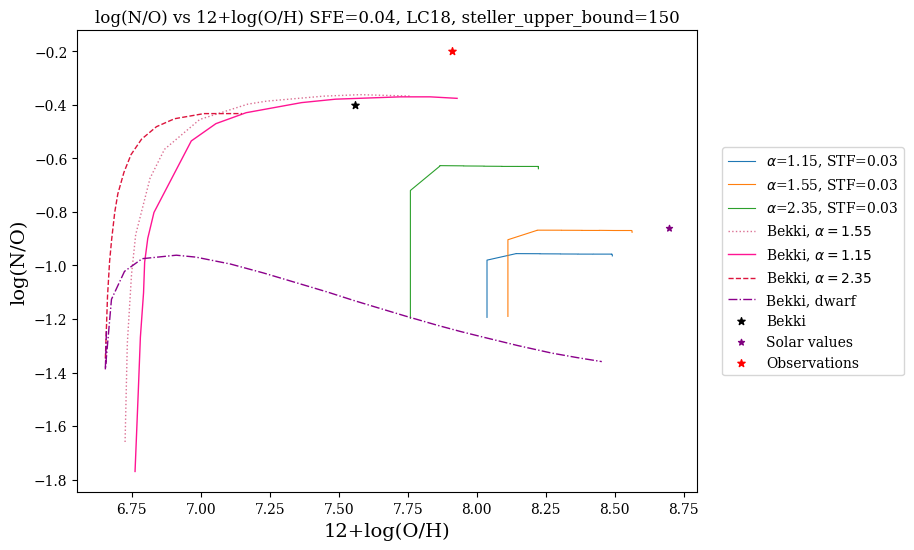

In [73]:
file_paths = glob.glob("./simulation_results_from_galaxy_evol/28.5/imfKroupaSTF0.05alpha*Log_SFR2.0SFEN10Z_0-4.15/chemical_and_SN_evolution.txt")
file_paths.sort()
print(file_paths)
labels = ['$\\alpha$=1.15, STF=0.03', '$\\alpha$=1.55, STF=0.03', '$\\alpha$=2.35, STF=0.03', '$\\alpha$=1.15, STF=0.05', '$\\alpha$=1.55, STF=0.05', '$\\alpha$=2.35, STF=0.05', '$\\alpha$=1.15, STF=0.07', '$\\alpha$=1.55, STF=0.07', '$\\alpha$=2.35, STF=0.07', '$\\alpha$=1.15, STF=0.09', '$\\alpha$=1.55, STF=0.09', '$\\alpha$=2.35, STF=0.09',]
plot_NO_OH_comparison(
    file_paths,
    labels=labels,
    index_x=10,
    index_y=100,
    title='log(N/O) vs 12+log(O/H) SFE=0.04, LC18, steller_upper_bound=150',
    filename='./figs/galevo/NO_OH_sfe=0.04_stel_up_bound=150_Lim.png',
    evolution_track_difference=False
)